In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%load_ext rpy2.ipython

## DATA CLEANING

In [4]:
data = pd.read_csv('/content/drive/Shareddrives/Time Series Final Project/Selected_Features_Crime_Data.csv')
data = data.drop('Unnamed: 0',axis = 1)
# Delete column Part and Weapon
data = data.drop(['Part 1-2','Weapon Used Cd'],axis = 1)
data = data.dropna()

In [5]:
# rerank them by date and time
def f(x):
  x = str(x)
  length = len(x)
  if length < 4:
    temp = (4 - length) * '0'
    x = temp + x
  if length >= 5:
    print('===')
  return x

data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])
data['TIME OCC'] = data['TIME OCC'].apply(lambda x: f(x))
df_s = data.sort_values(by=['DATE OCC','TIME OCC'])


In [6]:
# Delete 2023-10-09 for missing most of the crime events
df_s.drop(df_s[df_s['DATE OCC'] == '2023-10-09'].index, inplace=True)

In [7]:
df_s.to_csv('clean_data.csv')

## ARIMA related model to fit, diagnose and forcast daily crime counts

[None]

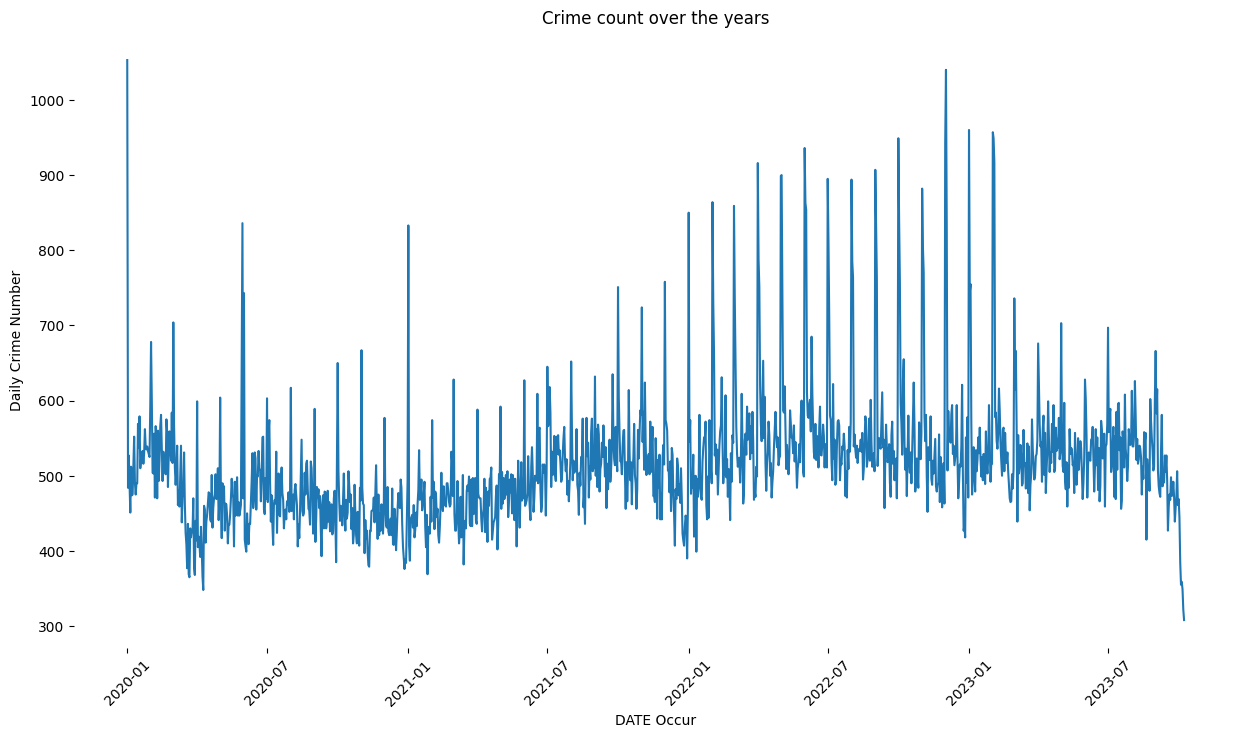

In [8]:
# Calculate daily crime count over the years
counts = df_s['DATE OCC'].value_counts().reset_index()
counts = counts.sort_values(by = 'index')
counts = counts.rename(columns={'index': 'DATE Occur','DATE OCC':'Daily Crime Number'})

plt.figure(figsize=(15,8))
a = sns.lineplot(x=counts['DATE Occur'],y=counts['Daily Crime Number'])

plt.xticks(rotation=45)
plt.title("Crime count over the years")
a.set(frame_on=False)



In [9]:
counts.to_csv('Daily Crime.csv')

In [10]:
# Copy dataframe df_ar to R
%R -i counts

/usr/local/lib/python3.10/dist-packages/rpy2/robjects/pandas2ri.py:55: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


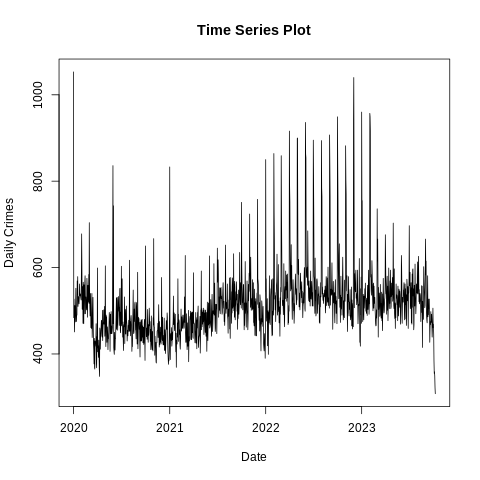

In [11]:
%%R
# Plot the same time series crime counts
date_sequence <- seq(as.Date("2020-01-01"), as.Date("2023-10-08"), by="1 day")
length(date_sequence)
# Daily Crimes
plot(date_sequence, counts[,c(2)], type="l", xlab="Date", ylab="Daily Crimes", main="Time Series Plot")



 [1] 1053  678  704  348  836  743  667  833  751  724  758  850  864  732  663
[16]  859  738  916  788  751  899  900  738  936  863  854  685  895  814  712
[31]  894  785  764  907  836  764  949  840  757  882  804  770  942 1040  835
[46]  960  744  755  957  949  917  736  666  676  703  697  666  355  349  322
[61]  308


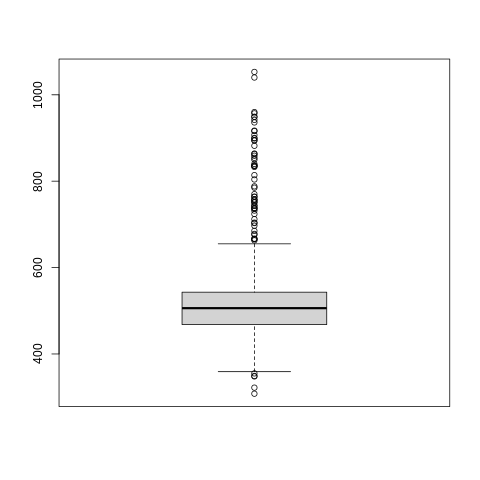

In [12]:
%%R
data <- counts[,c(2)]
outliers <- boxplot(data)$out
print(outliers)

In [13]:
%%R
start_date <- as.Date("2020-01-01")
daily_ts<- ts(counts[,c(2)], start=start_date, frequency=1)

outliers_index_upper <- which(daily_ts > mean(daily_ts) + 2 * sd(daily_ts))
outliers_index_lower <- which(daily_ts < mean(daily_ts) - 2 * sd(daily_ts))
print(outliers_index)

smooth_ts <- daily_ts
smooth_ts[outliers_index_upper] <- smooth_ts[outliers_index_upper]*0.5
smooth_ts[outliers_index_lower] <- smooth_ts[outliers_index_lower]*1.5
# ts_data_interp <- daily_ts
# ts_data_interp[outliers_index] <- NA
# ts_data_interp <- zoo::na.approx(ts_data_interp,rule=2)

plot(date_sequence,daily_ts, type = 'o', col = 'blue', pch = 16, main = 'Linear Interpolation for Outliers')
points(smooth_ts, col = 'red', pch = 16)
legend('topright', legend = c('Original', 'Interpolated'), col = c('blue', 'red'), pch = 16)



  object 'outliers_index' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'outliers_index' not found


In [14]:
%%R
# differencing
s_diff1 <- diff(smooth_ts,lag=30)
s_diff2 <- diff(smooth_ts,lag = 7)


plot(s_diff2, main="Differenced total Daily Crime Count")

  object 'smooth_ts' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'smooth_ts' not found


In [15]:
%%R
#install.packages("forecast")


NULL


In [16]:
%%R
library(forecast)
arima_model <- auto.arima(smooth_ts, D=1)

summary(arima_model)


Error in library(forecast) : there is no package called ‘forecast’


In [17]:
%%R
#install.packages('astsa')
#library(astsa)

NULL


In [18]:
%%R
acf2(s_diff2, max.lag=120)



Error in acf2(s_diff2, max.lag = 120) : could not find function "acf2"


In [19]:
%%R
sarima(daily_ts, p=0, d=0, q=0,P=2,D=1,Q=1,S=30,no.constant=T)


  could not find function "sarima"




Error in sarima(daily_ts, p = 0, d = 0, q = 0, P = 2, D = 1, Q = 1, S = 30,  : 
  could not find function "sarima"


## Weekly percentage

In [20]:
train=counts.head(1096)
train.reset_index(drop=True,inplace=True)
train

,DATE Occur,Daily Crime Number
0,2020-01-01,1053
1,2020-01-02,484
2,2020-01-03,527
3,2020-01-04,490
4,2020-01-05,451
...,...,...
1091,2022-12-27,418
1092,2022-12-28,551
1093,2022-12-29,491
1094,2022-12-30,578


In [21]:
train['percent']=train['Daily Crime Number']/pop
train['percent']=train['percent']*10000
train

NameError: ignored

In [ ]:
pop=np.linspace(10014009,10033549,367).tolist()+np.linspace(10033549,10053089,366).tolist()[1:]+np.linspace(10053089,10072629,366).tolist()[1:-1]

In [ ]:
plt.plot(train['DATE Occur'],train['percent'])

In [ ]:
week=train.loc[5:1089].reset_index(drop=True)
week

In [ ]:
week.groupby(np.arange(len(train))//7).mean()
week

In [ ]:
week.drop(['DATE Occur','Daily Crime Number'], axis=1, inplace=True)
week.reset_index(drop=True)
week

In [ ]:
week_rate = week.groupby(week.index // 7 ).mean().reset_index(drop=True)
week_rate

In [ ]:
date=np.linspace(2020,2022,155).tolist()

In [ ]:
plt.plot(date,week_rate['percent'])

In [ ]:
week_rate.to_csv('weekly_rate.csv')

###  model

In [ ]:
%%R
week_dat<- read.csv('weekly_rate.csv')
#asian_dat<- asian_dat[,-1]

#asian_dat$Week<- as.Date(asian_dat$DATE.OCC)

head(week_dat)

In [ ]:
%%R
week_ts <- ts(week_dat$percent, start = c(2020, 2), frequency = 365.25/7)
week_ts

In [ ]:
%%R
#asian_ts<- ts(asian_dat$count, start=c(2020, 1), frequency=12)
plot(diff(week_ts), main="Asian Victim Monthly Crime Count")

In [ ]:
%%R
install.packages('robustHD')

In [ ]:
%%R
library(robustHD)
week_winsorized=winsorize((week_ts),prob=c(0.1,0.9))
plot(week_winsorized)

In [ ]:
%%R
week=ts(week_winsorized, start = c(2020, 2),  frequency = 365.25/7)
week

In [ ]:
%%R
plot(diff(week))

In [ ]:
%%R
plot(diff(asian_ts), main="Differenced Asian Victim Monthly Crime Count")

In [ ]:
%%R
install.packages('astsa')
library(astsa)

In [ ]:
%%R
acf2(diff(diff(week),4), max.lag=30)

In [ ]:
%%R
sarima(week,1,1,1,1,1,1,4)

In [ ]:
%%R
#prediction
sarima.for(asian, n.ahead=12, p=0, d=1, q=1)

## Use monthly count

In [22]:
df_s

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent
160,2020-01-01,0001,1,440,25,F,F
1557,2020-01-01,0001,7,812,13,F,H
2392,2020-01-01,0001,3,745,41,M,H
2400,2020-01-01,0001,3,330,41,M,H
2405,2020-01-01,0001,3,740,34,F,W
...,...,...,...,...,...,...,...
808285,2023-10-08,2200,1,745,0,X,X
796476,2023-10-08,2237,18,230,33,F,B
811695,2023-10-08,2300,4,624,26,M,W
696817,2023-10-08,2311,11,761,22,M,H


In [ ]:
df_s['Week'] = df_s['DATE OCC'].dt.week
df_s

In [ ]:
df_s['Month'] = df_s['DATE OCC'].dt.to_period('M')
df_s

In [ ]:
df_s['Month'] = df_s['DATE OCC'].dt.to_period('M')
# Calculate monthly crime count over the years
counts_m = df_s['Month'].value_counts().reset_index()
counts_m = counts_m.sort_values(by = 'index')
counts_m = counts_m.rename(columns={'index': 'Month Occur','Month':'Monthly Crime Number'})
counts_m
# drop 2023-10

counts_m.drop(counts_m[counts_m['Month Occur']=='2023-10'].index,inplace=True)
counts_m

plt.figure(figsize=(15,8))
a = sns.lineplot(x=counts_m['Month Occur'].astype(str),y=counts_m['Monthly Crime Number'])

plt.xticks(rotation=45)
plt.title("Crime count over the years")
a.set(frame_on=False)


In [ ]:
counts_m.to_csv('Monthly Crime.csv',index = False)


In [ ]:
%%R
month_ts <- read.csv('Monthly Crime.csv')
month_ts


month_ts<- ts(month_ts$Monthly.Crime.Number, start=c(2020, 1), frequency=12)
plot(month_ts, main="Monthly Crime Count")



In [ ]:
%%R
plot(diff(month_ts), main="Differenced Monthly Crime Count")


In [ ]:
%%R
acf2(diff(month_ts), max.lag=20)

In [ ]:
%%R
sarima(month_ts, p=1, d=1, q=0, no.constant=T)


In [ ]:
%%R
sarima.for(month_ts, n.ahead=6, p=1, d=1, q=0)


In [ ]:
# DATA CLEANING
# Delete all rows that Vict Age <= 0
df_s.drop(df_s[df_s['Vict Age'] <= 0].index,inplace=True)
# Drop NaN Descent
df_s.drop(df_s[df_s['Vict Descent'] == '-'].index,inplace=True)


## PLOT CRIME COUNT OVER VICTIM SEX(MALE & FEMALE)


In [ ]:
sex = ['M','F']
col = ['blue','green']
fig, axes = plt.subplots(1, 2, sharex=True,sharey=True,figsize = (16,6))

for i in range(len(sex)):
  df_sex = df_s[df_s['Vict Sex'] == sex[i]]

  # Calculate daily crime count (descent)
  counts_sex = df_sex['DATE OCC'].value_counts().reset_index()
  counts_sex = counts_sex.sort_values(by = 'index')
  counts_sex = counts_sex.rename(columns={'index': 'DATE Occur','DATE OCC':'Daily Crime Number'})

  a = sns.lineplot(x=counts_sex['DATE Occur'],y=counts_sex['Daily Crime Number'],color =col[i],ax = axes[i] )
  #plt.xticks(rotation=45)
  #axes[i].set_xticks(count[i]['DATE Occur'])
  axes[i].set_title(f"Crime count with {sex[i]} victims ")
  a.set(frame_on=False)




In [ ]:
# Relabel all the other descent that are not: H, W, B, A, O, X to "others"
def descent(x):
  if (x != 'H' and x != 'W' and x != 'O' and x != 'B' and x != 'A' and x != 'X'):
    x = 'Others'
  return x
df_s['Vict Descent'] = df_s['Vict Descent'].apply(lambda x: descent(x))



## PLOT CRIME COUNT OVER VICTIM DESCENT
### White(W), Hispanic(H), Black(B), Asian(A)

In [ ]:
race = ['W','H','B','A']
col = ['blue','green','orange','red']
fig, axes = plt.subplots(1, 4, sharex=True,sharey=True,figsize = (32,6))

df_asian = df_s[df_s['Vict Descent'] == 'A']
for i in range(len(race)):
  df_descent = df_s[df_s['Vict Descent'] == race[i]]

  # Calculate daily crime count (descent)
  counts_descent = df_descent['DATE OCC'].value_counts().reset_index()
  counts_descent = counts_descent.sort_values(by = 'index')
  counts_descent = counts_descent.rename(columns={'index': 'DATE Occur','DATE OCC':'Daily Crime Number'})

  a = sns.lineplot(x=counts_descent['DATE Occur'],y=counts_descent['Daily Crime Number'],color =col[i],ax = axes[i] )
  #plt.xticks(rotation=45)
  #axes[i].set_xticks(count[i]['DATE Occur'])
  axes[i].set_title(f"Crime count with {race[i]} victims ")
  a.set(frame_on=False)


In [27]:
df_asian = df_s[df_s['Vict Descent'] == 'A']
df_black = df_s[df_s['Vict Descent'] == 'B']
df_hispanic = df_s[df_s['Vict Descent'] == 'H']
df_white = df_s[df_s['Vict Descent'] == 'W']

## Asian

### Asian data

In [28]:
df_asian

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent
13455,2020-01-01,0001,14,815,4,M,A
70104,2020-01-01,0001,14,815,2,M,A
155387,2020-01-01,0001,20,341,34,M,A
87563,2020-01-01,0100,6,230,30,M,A
31814,2020-01-01,0150,6,420,62,F,A
...,...,...,...,...,...,...,...
695300,2023-10-07,2250,6,210,60,M,A
708564,2023-10-07,2300,20,330,21,M,A
733232,2023-10-07,2300,7,330,24,M,A
799035,2023-10-08,1420,1,625,33,F,A


In [29]:
asian_count=df_asian.groupby('DATE OCC').size().reset_index(name='count')
asian_count

,DATE OCC,count
0,2020-01-01,25
1,2020-01-02,16
2,2020-01-03,17
3,2020-01-04,10
4,2020-01-05,8
...,...,...
1372,2023-10-04,14
1373,2023-10-05,10
1374,2023-10-06,6
1375,2023-10-07,10


In [30]:
asian_count=asian_count.loc[5:]
asian_count.reset_index(drop=True,inplace=True)

In [31]:
asian_count.drop('DATE OCC', axis=1, inplace=True)
asian_count.reset_index(drop=True)

<ipython-input-31-bee4bf123b73>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asian_count.drop('DATE OCC', axis=1, inplace=True)


,count
0,19
1,18
2,16
3,12
4,17
...,...
1367,14
1368,10
1369,6
1370,10


In [32]:
asian = asian_count.groupby(asian_count.index // 7 ).sum().reset_index(drop=True)


In [33]:
asian

,count
0,104
1,118
2,116
3,120
4,117
...,...
191,99
192,96
193,102
194,83


In [34]:
asian.to_csv('asian_week.csv')

### Asian model

In [35]:
%%R
asian_dat<- read.csv('asian_week.csv')
#asian_dat<- asian_dat[,-1]

#asian_dat$Week<- as.Date(asian_dat$DATE.OCC)

head(asian_dat)

  X count
1 0   104
2 1   118
3 2   116
4 3   120
5 4   117
6 5   112


In [36]:
%%R
asian_ts <- ts(asian_dat$count, start = c(2020, 2), frequency = 365.25/7)
asian_ts

Time Series:
Start = 2020.01916495551 
End = 2023.75633127995 
Frequency = 52.1785714285714 
  [1] 104 118 116 120 117 112 124 126  89  96  77  62  70  73  83  96  77  82
 [19]  73  88  92  55  75  73  82  85  67  88  77  87  76  77  62  82  89  58
 [37]  91  86  78  78  79  75  74  69  84  59  83  87  78  89  72  75  99  81
 [55]  62  79  86  74  67  70  75  84  79  75  78  75  61  81  71  69  76  67
 [73]  71  89  81  92  66  73  98  97  71  89  89  68  95  90 105  95  74  95
 [91]  83  97  84  80 109  89  90  93  91 114  85  79  78  98  75  92 101  92
[109] 108 116 100  98  96  90  88  99 114  88  88 101 106  99 111  89  84  90
[127]  92  91  96 106  88  99  83  94 119 102  90 110 105 104 107 106 131  98
[145] 105 106  92 123  86  89 111 123 101 116 127 120 105  92 103  99 125  93
[163] 112  82  84  97 103  80 117  93 104  88  95  87  80 101  98  92  86  89
[181] 113 101  87  96  96  81 122  98  83 104 112  99  96 102  83  61


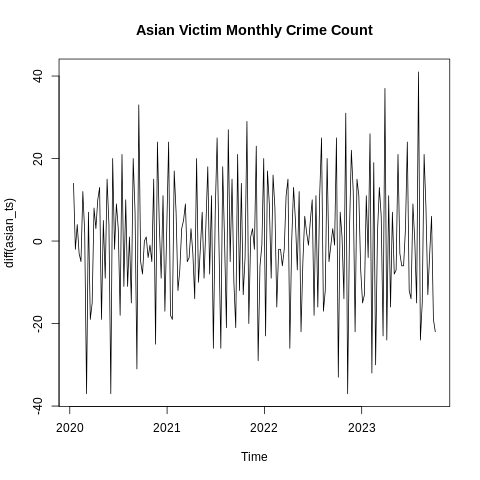

In [37]:
%%R
#asian_ts<- ts(asian_dat$count, start=c(2020, 1), frequency=12)
plot(diff(asian_ts), main="Asian Victim Monthly Crime Count")

In [38]:
%%R
install.packages('robustHD')

(as ‘lib’ is unspecified)


































	‘/tmp/RtmpuJWoCf/downloaded_packages’



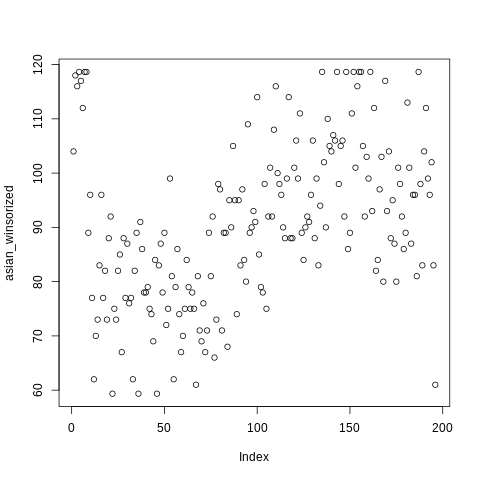

In [39]:
%%R
library(robustHD)
asian_winsorized=winsorize((asian_ts),prob=c(0.1,0.9))
plot(asian_winsorized)

In [40]:
%%R
asian=ts(asian_winsorized, start = c(2020, 2),  frequency = 365.25/7)
asian

Time Series:
Start = 2020.01916495551 
End = 2023.75633127995 
Frequency = 52.1785714285714 
  [1] 104.000 118.000 116.000 118.652 117.000 112.000 118.652 118.652  89.000
 [10]  96.000  77.000  62.000  70.000  73.000  83.000  96.000  77.000  82.000
 [19]  73.000  88.000  92.000  59.348  75.000  73.000  82.000  85.000  67.000
 [28]  88.000  77.000  87.000  76.000  77.000  62.000  82.000  89.000  59.348
 [37]  91.000  86.000  78.000  78.000  79.000  75.000  74.000  69.000  84.000
 [46]  59.348  83.000  87.000  78.000  89.000  72.000  75.000  99.000  81.000
 [55]  62.000  79.000  86.000  74.000  67.000  70.000  75.000  84.000  79.000
 [64]  75.000  78.000  75.000  61.000  81.000  71.000  69.000  76.000  67.000
 [73]  71.000  89.000  81.000  92.000  66.000  73.000  98.000  97.000  71.000
 [82]  89.000  89.000  68.000  95.000  90.000 105.000  95.000  74.000  95.000
 [91]  83.000  97.000  84.000  80.000 109.000  89.000  90.000  93.000  91.000
[100] 114.000  85.000  79.000  78.000  98.000  75

In [ ]:
%%R
install.packages("forecast")

In [ ]:
%%R
install.packages("astsa")
library("astsa")

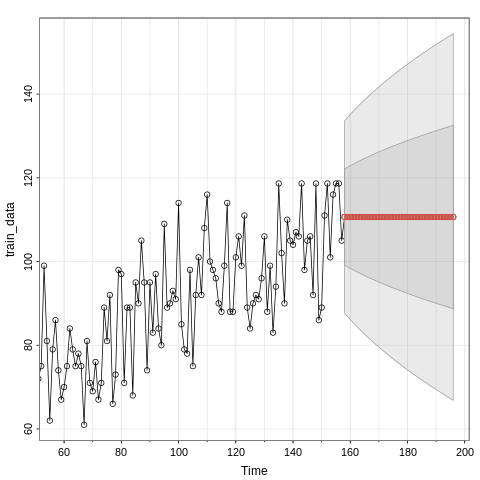

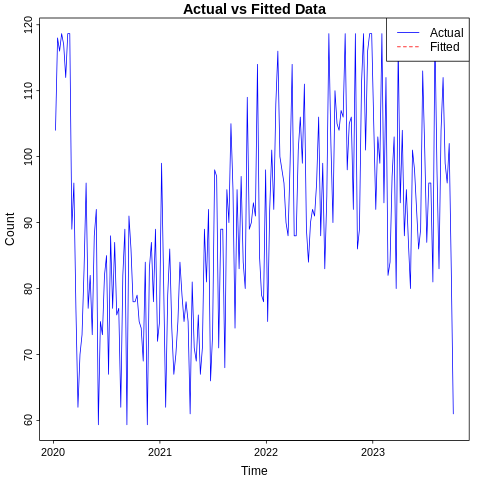

In [52]:
%%R
training_proportion <- 0.8
num_obs <- length(asian)
num_train <- round(num_obs * training_proportion)

# Split the data into training and testing sets
train_data <- asian[1:num_train]
test_data <- asian[(num_train + 1):length(asian)]

# Fit an ARIMA model to the training data
arima_model <- arima(train_data, order=c(0,1,1))  # You can adjust the order as needed

# Make predictions on the testing data
predicted_values <- sarima.for(train_data,n.ahead=length(test_data), p=0, d=1, q=1,no.constant=T)

# Plot the actual data and the fitted data together
plot(asian, main = 'Actual vs Fitted Data', col = 'blue', ylab = 'Count', xlab = 'Time')
lines(predicted_values$pred, col = 'red', lty = 2)  # Dashed line for fitted data
legend("topright", legend = c("Actual", "Fitted"), col = c('blue', 'red'), lty = c(1, 2))


  method            from
  as.zoo.data.frame zoo 

Attaching package: ‘forecast’



    gas




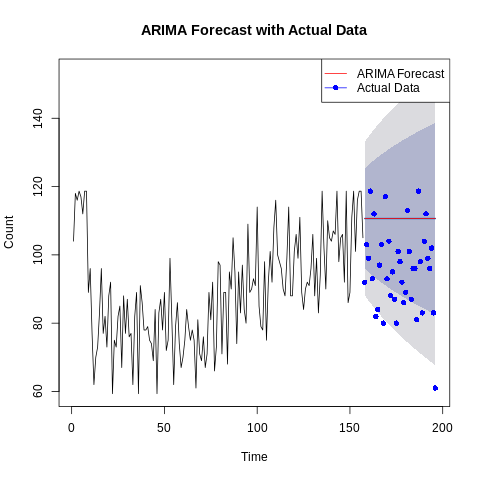

In [54]:
%%R
library(forecast)
# Assuming 'sarima_forecast' is your SARIMA forecast object
sarima_forecast <- forecast(arima_model, h = length(test_data))

# Create a plot object
forecast_plot <- plot(sarima_forecast, main = 'ARIMA Forecast with Actual Data', ylab = 'Count', xlab = 'Time')
# Add the actual data points
points(158:196, test_data, col = 'blue', pch = 16)

# Add the prediction line with a custom color
lines(sarima_forecast$mean, col = 'red')
legend("topright", legend = c("ARIMA Forecast", "Actual Data"), col = c('red', 'blue'), lty = c(1, 1), pch = c(NA, 16))

# Save the plot to a file (optional)
# png("sarima_forecast_plot.png")
# print(forecast_plot)
# dev.off()


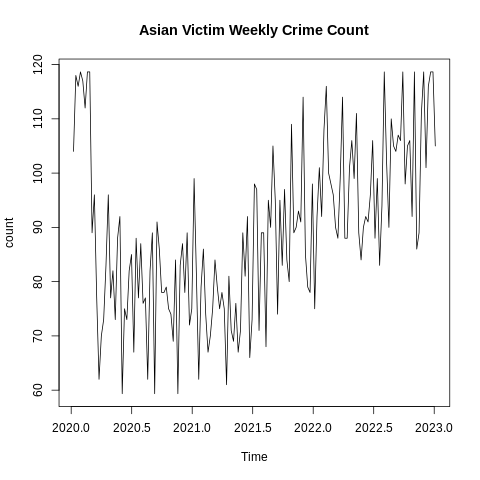

In [60]:
%%R
asian_train=ts(train_data,start = c(2020, 2),  frequency = 365.25/7)
plot((asian_train),main='Asian Victim Weekly Crime Count',ylab='count')

In [45]:
%%R
plot(diff(train), main="Differenced Asian Victim Weekly Crime Count")

  error in evaluating the argument 'x' in selecting a method for function 'plot': object 'train' not found




Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'plot': object 'train' not found


      [,1]  [,2] [,3]  [,4] [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11] [,12]
ACF  -0.43 -0.15  0.2 -0.14 0.11 -0.07 -0.05  0.04 -0.02  0.03 -0.07  0.03
PACF -0.43 -0.41 -0.1 -0.18 0.03 -0.06 -0.09 -0.12 -0.10 -0.04 -0.12 -0.09
     [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24]
ACF   0.13 -0.04 -0.09  0.02  0.03 -0.05  0.08 -0.11  0.02  0.12 -0.11  0.05
PACF  0.09  0.15  0.03 -0.05 -0.05 -0.11  0.04 -0.06 -0.03  0.07  0.02  0.05
     [,25] [,26] [,27] [,28] [,29] [,30]
ACF  -0.01  0.01  0.00 -0.06  0.03 -0.02
PACF  0.00  0.01 -0.04 -0.03 -0.02 -0.04


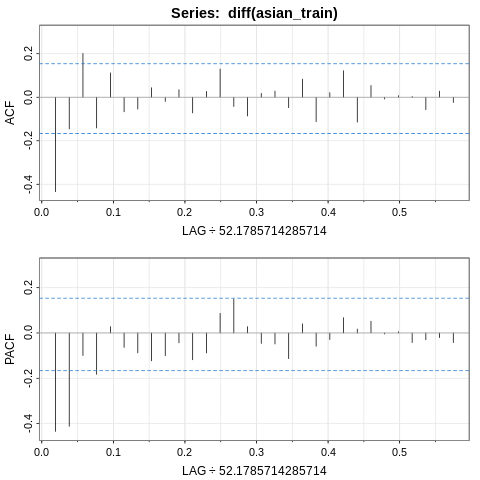

In [61]:
%%R
acf2(diff(asian_train), max.lag=30)

initial  value 2.653598 
iter   2 value 2.496145
iter   3 value 2.459105
iter   4 value 2.449672
iter   5 value 2.446306
iter   6 value 2.444891
iter   7 value 2.443669
iter   8 value 2.443517
iter   9 value 2.442859
iter  10 value 2.442843
iter  11 value 2.442843
iter  11 value 2.442843
final  value 2.442843 
converged
initial  value 2.443229 
iter   2 value 2.443210
iter   3 value 2.443138
iter   4 value 2.443110
iter   5 value 2.443110
iter   5 value 2.443110
iter   5 value 2.443110
final  value 2.443110 
converged
$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    xreg = constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ma1  constant
      -0.7364   -0.0001
s.e.   0.0559    0.2468

sigma^2 estimated as 131.8:  log likelihood = -602.48,  aic = 1210.96

$degrees_of_freedom
[1] 154

$ttable
         Estimate     SE  t.value p.value
ma1      

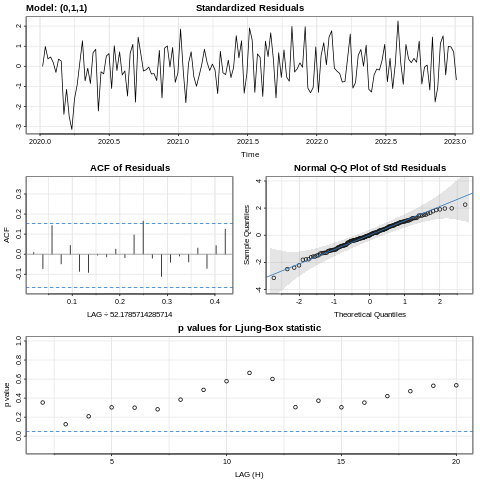

In [62]:
%%R
sarima(asian_train, p=0, d=1, q=1,no.constant=F)

In [49]:
%%R
#prediction
sarima.for(train, n.ahead=12, p=0, d=1, q=1,no.constant=T)

  object 'train' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'train' not found


### Asian plot

In [50]:
asian_data=pd.read_csv('/content/asian_month.csv')
ts=asian_data[['DATE OCC','count']]
ts['month']=ts['DATE OCC'].str[:7].astype('string')
ts['month'] = pd.to_datetime(ts['month'], format='%Y-%m')
print(ts.head())

FileNotFoundError: ignored

In [ ]:
ts=ts[['month','count']]
ts.index = ts['month']
del ts['month']
print(ts.head())
ts_asian=ts

In [63]:
asian['count']

0      104
1      118
2      116
3      120
4      117
      ... 
191     99
192     96
193    102
194     83
195     61
Name: count, Length: 196, dtype: int64

In [64]:
from datetime import timedelta

# Define the start and end dates
start_date = pd.to_datetime("2019-12-30")  # Assuming the first day of 2020 is in the first week
end_date = pd.to_datetime("2023-10-01")

# Generate the range of dates
date_range = pd.date_range(start=start_date, end=end_date, freq="W")

date_range


DatetimeIndex(['2020-01-05', '2020-01-12', '2020-01-19', '2020-01-26',
               '2020-02-02', '2020-02-09', '2020-02-16', '2020-02-23',
               '2020-03-01', '2020-03-08',
               ...
               '2023-07-30', '2023-08-06', '2023-08-13', '2023-08-20',
               '2023-08-27', '2023-09-03', '2023-09-10', '2023-09-17',
               '2023-09-24', '2023-10-01'],
              dtype='datetime64[ns]', length=196, freq='W-SUN')

In [65]:
ts=pd.DataFrame({'date':date_range,'count':asian['count']})
ts

,date,count
0,2020-01-05,104
1,2020-01-12,118
2,2020-01-19,116
3,2020-01-26,120
4,2020-02-02,117
...,...,...
191,2023-09-03,99
192,2023-09-10,96
193,2023-09-17,102
194,2023-09-24,83


Text(0.5, 1.0, 'Weekly Crime Count of Asian')

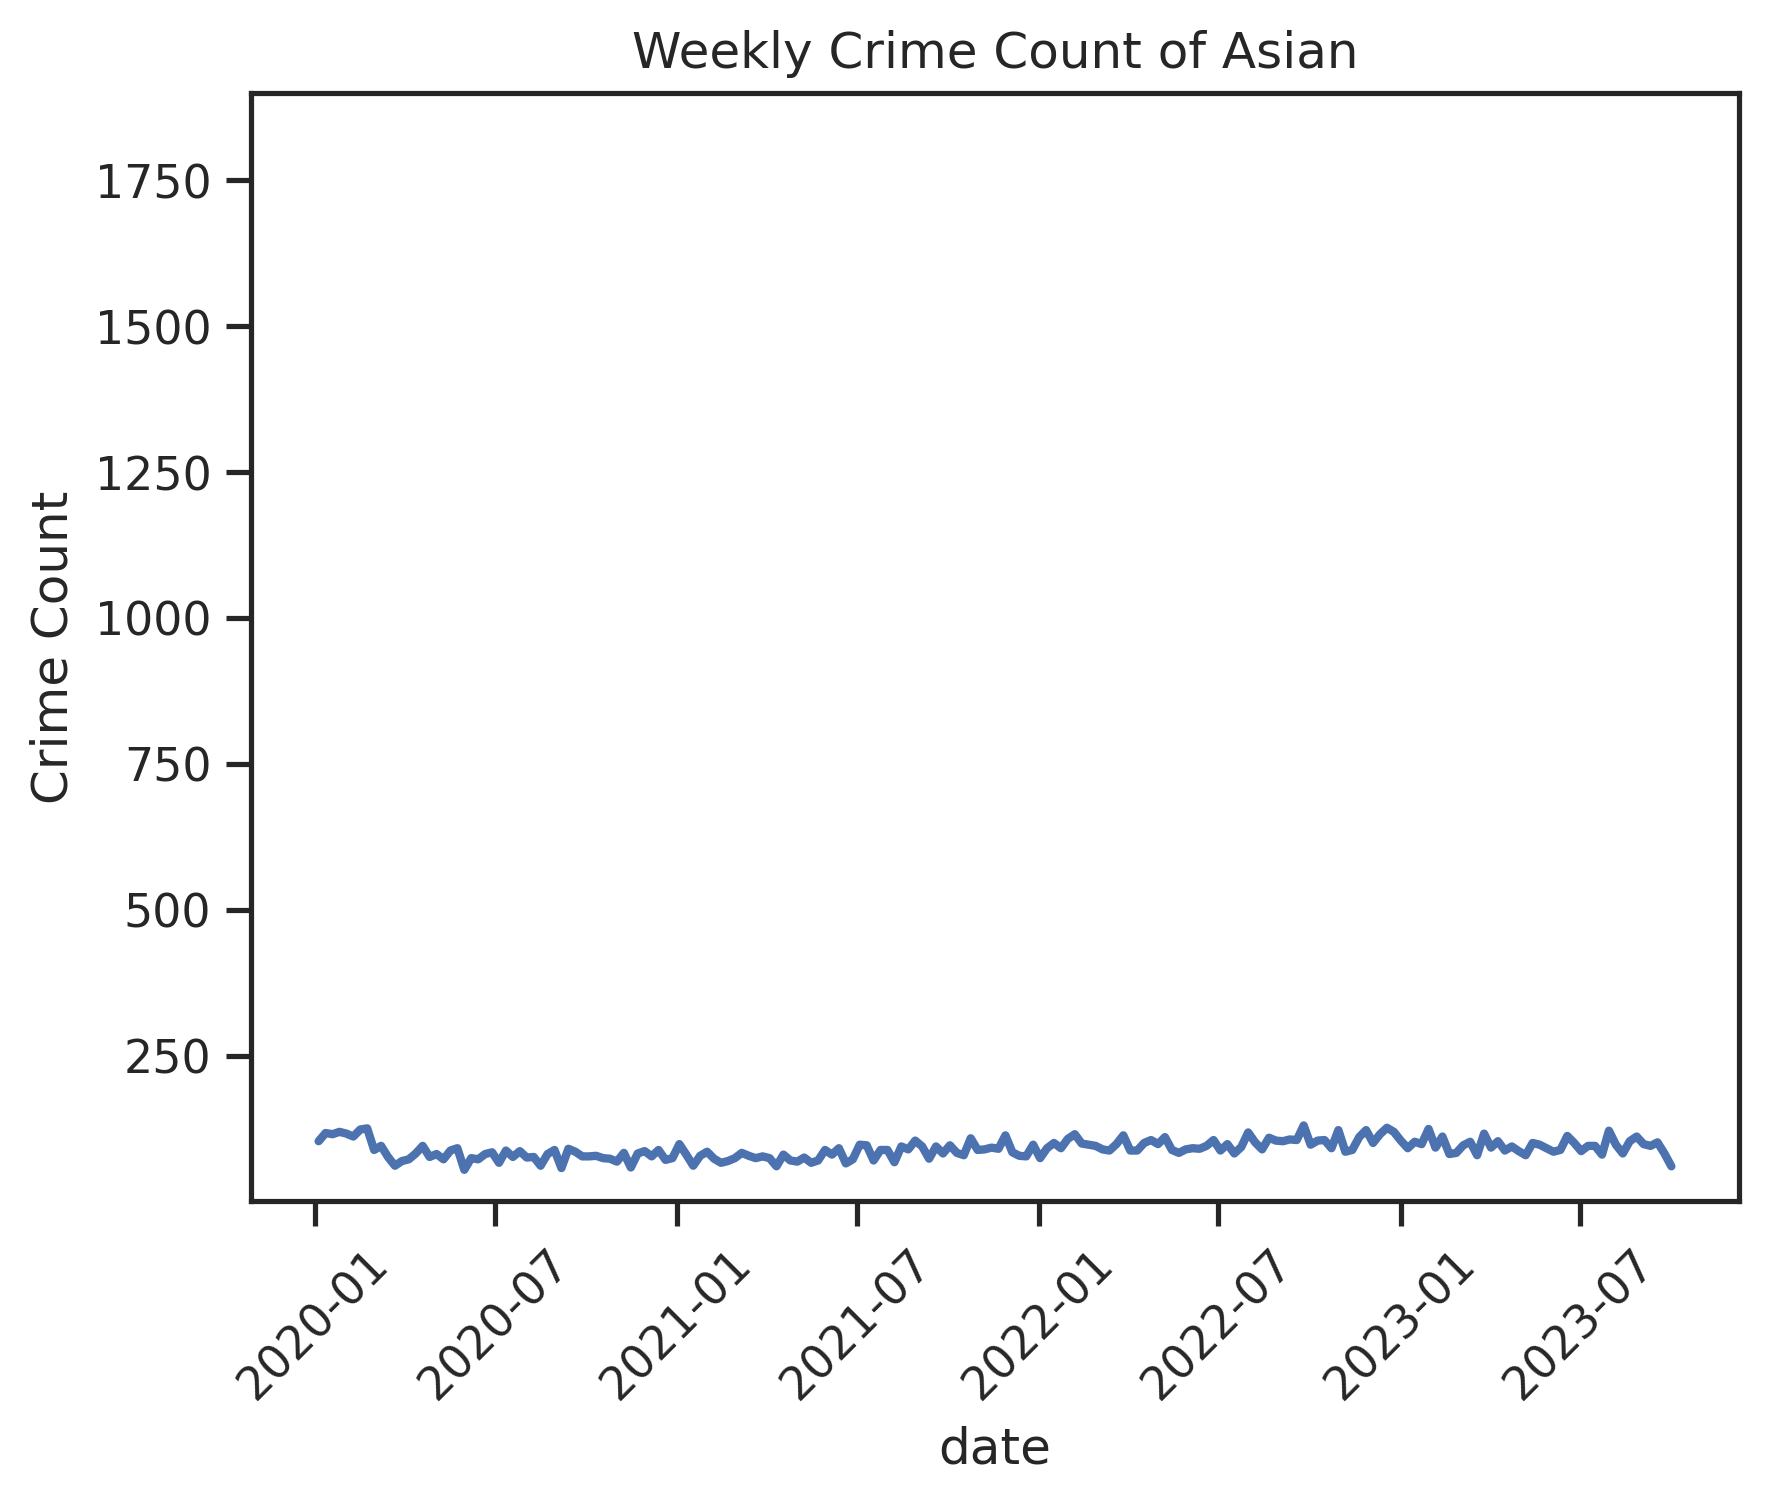

In [66]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

fig, ax = plt.subplots()
sns.lineplot(x='date',y='count',data=ts,linewidth=2,ax=ax)
ax.set_ylim(1,1900)
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.title("Weekly Crime Count of Asian")

Text(0.5, 1.0, 'Monthly Crime Count of Asian')

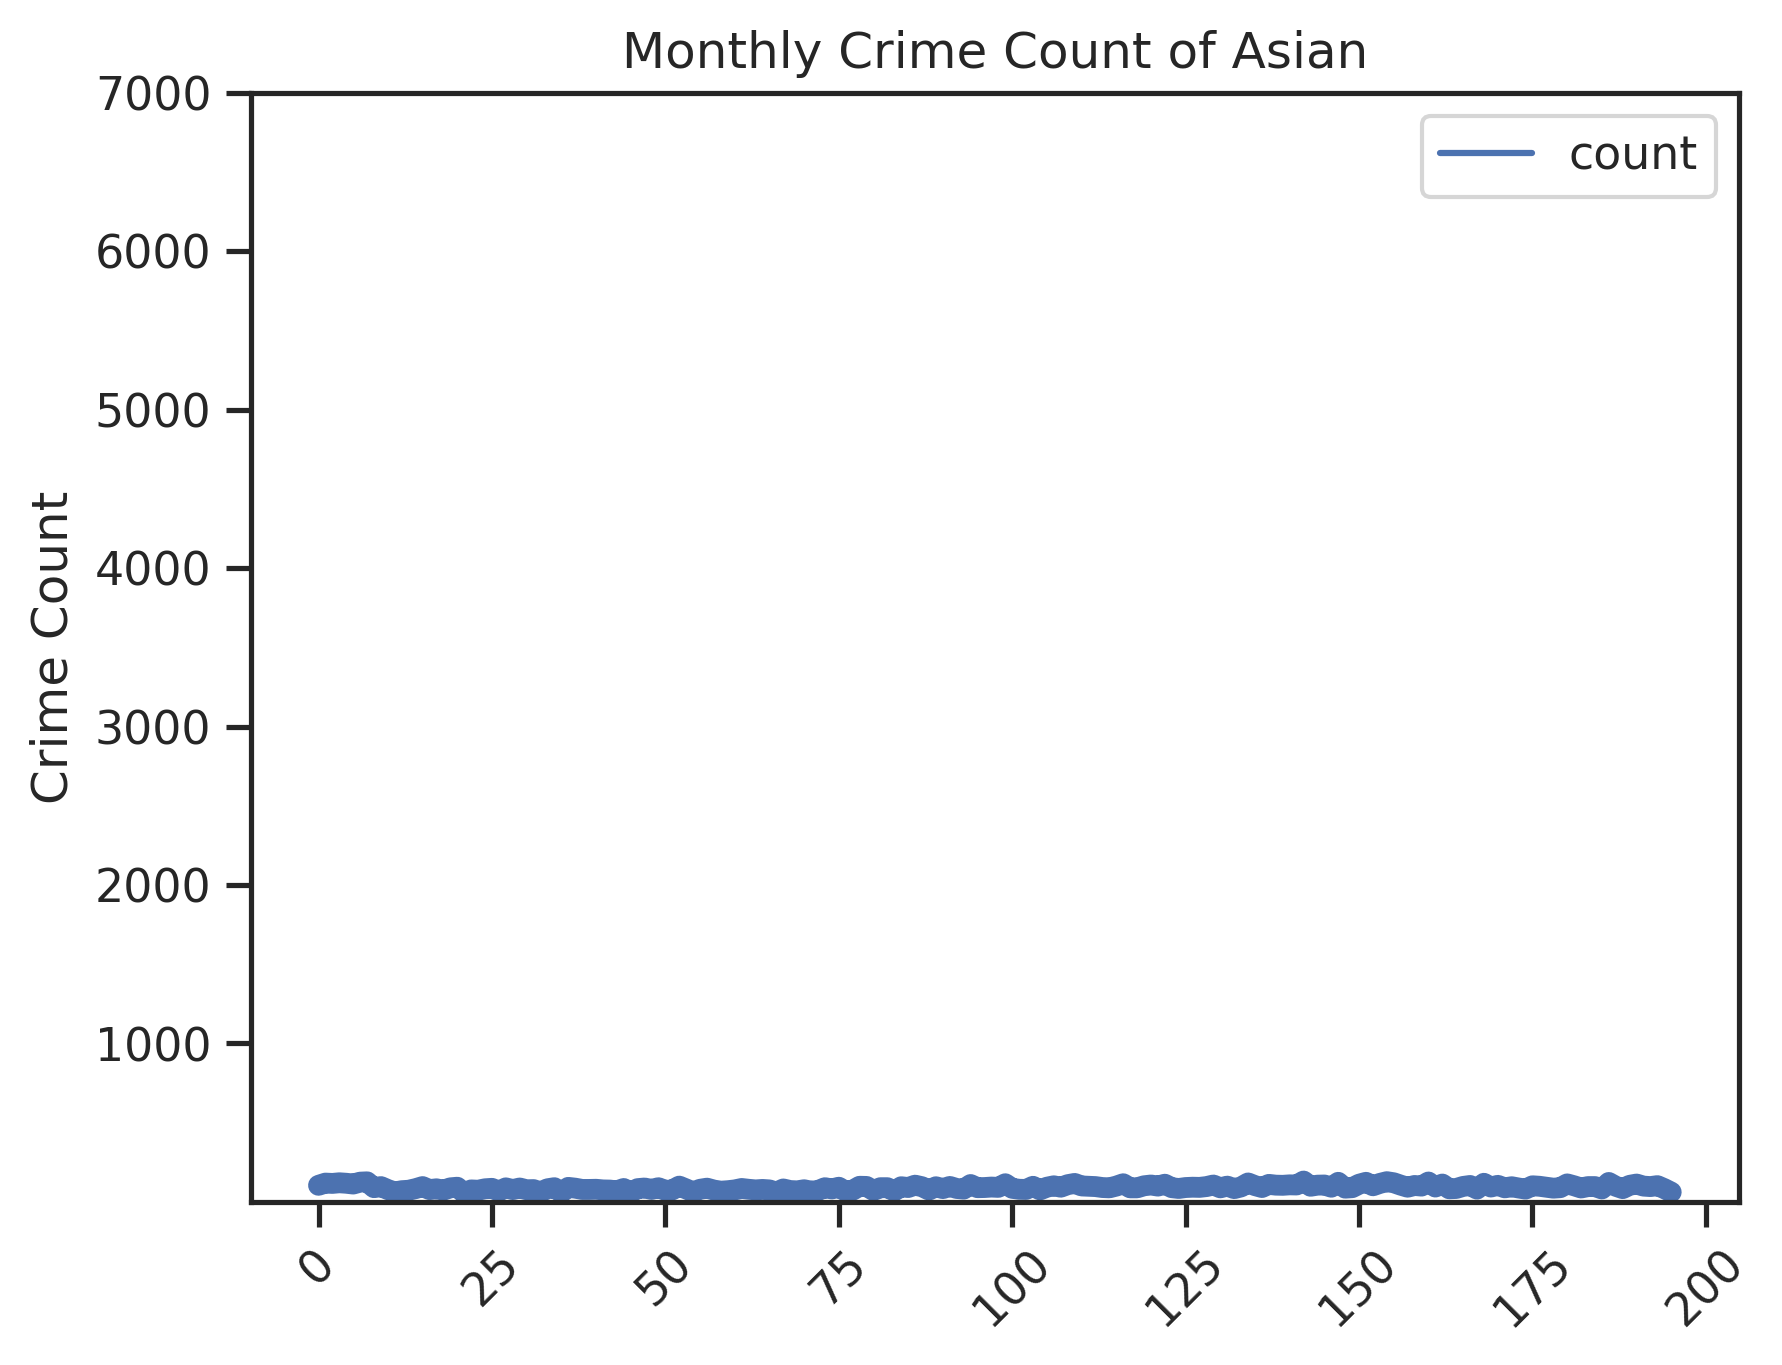

In [67]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

fig, ax = plt.subplots()
sns.lineplot(ts,linewidth=5,ax=ax)
ax.set_ylim(1,7000)
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.title("Monthly Crime Count of Asian")

## Black

### Black data

In [68]:
df_black

,DATE OCC,TIME OCC,AREA,Crm Cd,Vict Age,Vict Sex,Vict Descent
2450,2020-01-01,0001,3,310,66,F,B
13360,2020-01-01,0001,21,354,25,F,B
13363,2020-01-01,0001,18,815,10,F,B
13479,2020-01-01,0001,21,354,43,M,B
13753,2020-01-01,0001,18,820,6,F,B
...,...,...,...,...,...,...,...
649044,2023-10-08,2145,12,626,16,F,B
743804,2023-10-08,2145,4,888,38,M,B
675338,2023-10-08,2200,12,745,32,F,B
715986,2023-10-08,2200,12,753,41,M,B


In [69]:
black_count=df_black.groupby('DATE OCC').size().reset_index(name='count')
black_count

,DATE OCC,count
0,2020-01-01,165
1,2020-01-02,84
2,2020-01-03,93
3,2020-01-04,87
4,2020-01-05,78
...,...,...
1372,2023-10-04,62
1373,2023-10-05,64
1374,2023-10-06,63
1375,2023-10-07,45


In [70]:
black_count=black_count.loc[5:]
black_count.reset_index(drop=True,inplace=True)

In [71]:
black_count.drop('DATE OCC', axis=1, inplace=True)
black_count.reset_index(drop=True)

<ipython-input-71-f9f23009e88c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  black_count.drop('DATE OCC', axis=1, inplace=True)


,count
0,92
1,75
2,69
3,80
4,72
...,...
1367,62
1368,64
1369,63
1370,45


In [72]:
black = black_count.groupby(black_count.index // 7 ).sum().reset_index(drop=True)
black

,count
0,555
1,540
2,630
3,652
4,593
...,...
191,535
192,526
193,481
194,525


In [73]:
black.to_csv('black_week.csv')

### Black model

In [74]:
%%R
black_dat<- read.csv('black_week.csv')
#black_dat<- black_dat[,-1]

#asian_dat$Week<- as.Date(asian_dat$DATE.OCC)

head(black_dat)

  X count
1 0   555
2 1   540
3 2   630
4 3   652
5 4   593
6 5   576


In [75]:
%%R
black_ts <- ts(black_dat$count, start = c(2020, 1), frequency = 365.25/7)
black_ts

Time Series:
Start = 2020 
End = 2023.73716632444 
Frequency = 52.1785714285714 
  [1]  555  540  630  652  593  576  571  644  621  551  426  435  520  420  476
 [16]  526  503  528  503  493  536  524  501  572  592  607  522  575  567  593
 [31]  577  601  624  572  590  523  546  517  568  568  575  528  550  540  475
 [46]  559  535  541  489  530  501  543  514  540  531  474  583  497  523  546
 [61]  566  495  523  520  571  544  559  534  594  568  541  504  562  651  607
 [76]  624  618  663  642  604  629  611  632  561  570  619  645  634  591  611
 [91]  666  662  572  609  623  677  594  515  564  663  535  492  477  621  541
[106]  519  508  540  770  633  584  540  922  601  589  587  861  717  587  553
[121]  693  898  612  602  615  961  687  626  630  916  733  622  584  588  869
[136]  666  576  616  855  617  608  574  841  809  568  556  565  882  546  520
[151]  551  986  632  554  553  643  698  580  540  558 1008  612  521  478  595
[166]  528  495  584  626  5

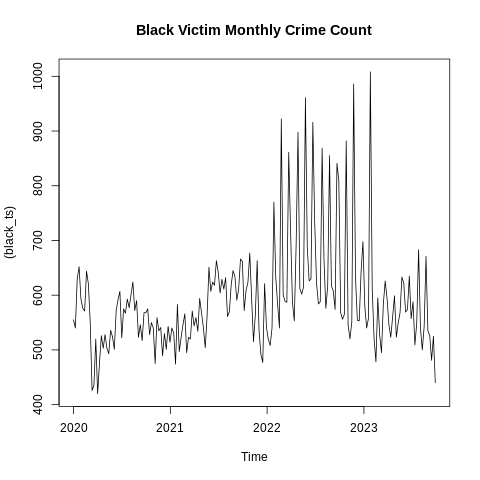

In [76]:
%%R
#asian_ts<- ts(asian_dat$count, start=c(2020, 1), frequency=12)
plot((black_ts), main="Black Victim Monthly Crime Count")

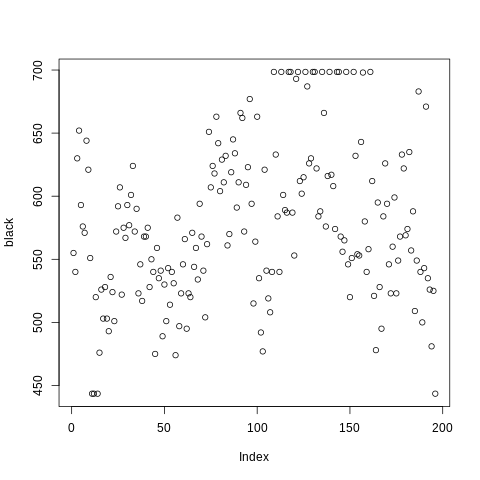

In [77]:
%%R
library(robustHD)
black=winsorize(black_ts,prob=c(0.1,0.9))
plot(black)

In [78]:
%%R
black=ts(black, start = c(2020, 1), frequency = 365.25/7)
black

Time Series:
Start = 2020 
End = 2023.73716632444 
Frequency = 52.1785714285714 
  [1] 555.0000 540.0000 630.0000 652.0000 593.0000 576.0000 571.0000 644.0000
  [9] 621.0000 551.0000 443.4964 443.4964 520.0000 443.4964 476.0000 526.0000
 [17] 503.0000 528.0000 503.0000 493.0000 536.0000 524.0000 501.0000 572.0000
 [25] 592.0000 607.0000 522.0000 575.0000 567.0000 593.0000 577.0000 601.0000
 [33] 624.0000 572.0000 590.0000 523.0000 546.0000 517.0000 568.0000 568.0000
 [41] 575.0000 528.0000 550.0000 540.0000 475.0000 559.0000 535.0000 541.0000
 [49] 489.0000 530.0000 501.0000 543.0000 514.0000 540.0000 531.0000 474.0000
 [57] 583.0000 497.0000 523.0000 546.0000 566.0000 495.0000 523.0000 520.0000
 [65] 571.0000 544.0000 559.0000 534.0000 594.0000 568.0000 541.0000 504.0000
 [73] 562.0000 651.0000 607.0000 624.0000 618.0000 663.0000 642.0000 604.0000
 [81] 629.0000 611.0000 632.0000 561.0000 570.0000 619.0000 645.0000 634.0000
 [89] 591.0000 611.0000 666.0000 662.0000 572.0000 609.0000 6

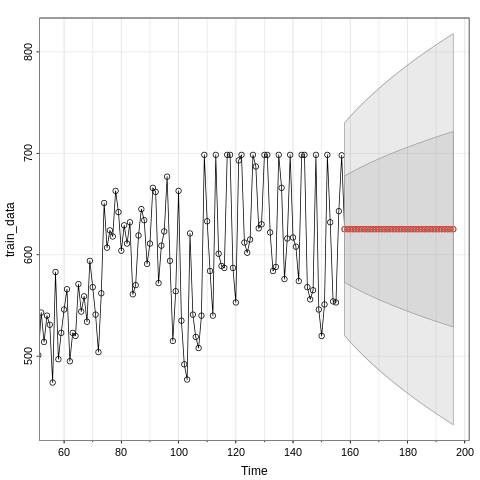

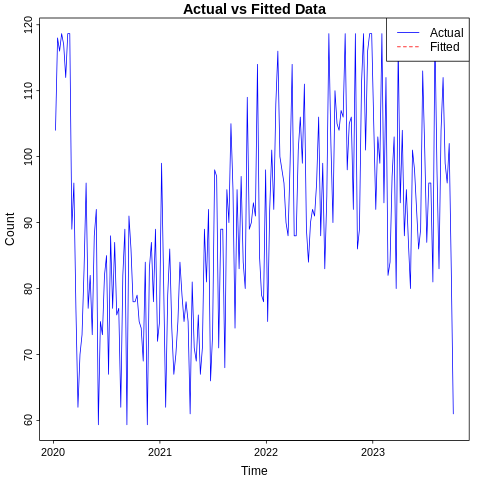

In [79]:
%%R
training_proportion <- 0.8
num_obs <- length(black)
num_train <- round(num_obs * training_proportion)

# Split the data into training and testing sets
train_data <- black[1:num_train]
test_data <- black[(num_train + 1):length(asian)]

# Fit an ARIMA model to the training data
arima_model <- arima(train_data, order=c(0,1,1),seasonal = list(order = c(1, 1, 0), period = 13))  # You can adjust the order as needed

# Make predictions on the testing data
predicted_values <- sarima.for(train_data,n.ahead=length(test_data), p=0, d=1, q=1,no.constant=T)

# Plot the actual data and the fitted data together
plot(asian, main = 'Actual vs Fitted Data', col = 'blue', ylab = 'Count', xlab = 'Time')
lines(predicted_values$pred, col = 'red', lty = 2)  # Dashed line for fitted data
legend("topright", legend = c("Actual", "Fitted"), col = c('blue', 'red'), lty = c(1, 2))


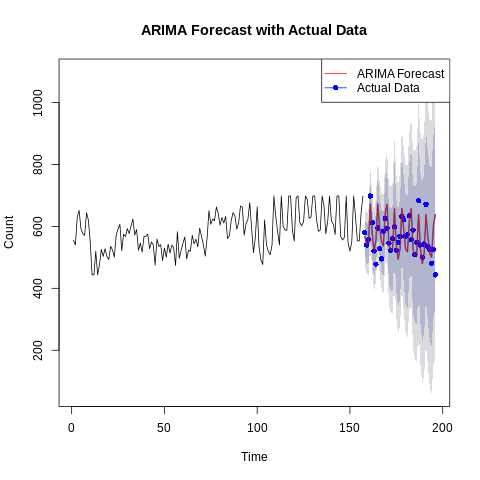

In [80]:
%%R
# Assuming 'sarima_forecast' is your SARIMA forecast object
sarima_forecast <- forecast(arima_model, h = length(test_data))

# Create a plot object
forecast_plot <- plot(sarima_forecast, main = 'ARIMA Forecast with Actual Data', ylab = 'Count', xlab = 'Time')
# Add the actual data points
points(158:196, test_data, col = 'blue', pch = 16)

# Add the prediction line with a custom color
lines(sarima_forecast$mean, col = 'red')
legend("topright", legend = c("ARIMA Forecast", "Actual Data"), col = c('red', 'blue'), lty = c(1, 1), pch = c(NA, 16))

# Save the plot to a file (optional)
# png("sarima_forecast_plot.png")
# print(forecast_plot)
# dev.off()


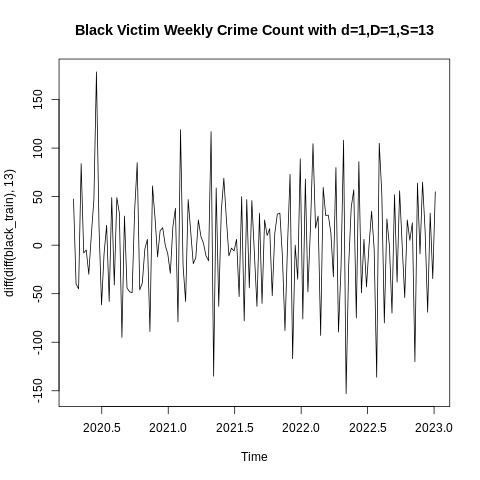

In [88]:
%%R
black_train=ts(train_data,start=c(2020,2),frequency=365.25/7)
plot(diff(diff(black_train),13),main="Black Victim Weekly Crime Count with d=1,D=1,S=13")

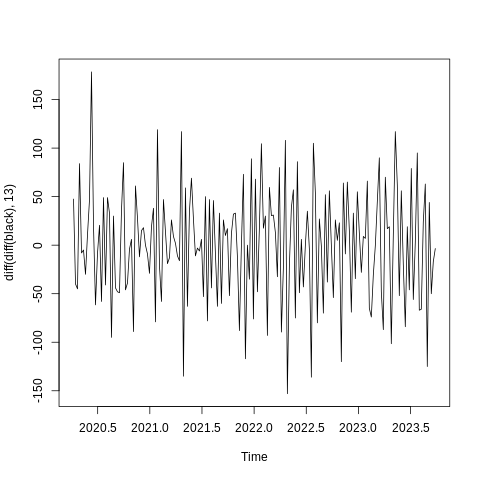

In [82]:
%%R
plot(diff(diff(black),13))

      [,1]  [,2]  [,3]  [,4]  [,5]  [,6] [,7]  [,8] [,9] [,10] [,11] [,12]
ACF  -0.39 -0.04  0.01  0.01  0.01 -0.04 0.05 -0.03 0.06 -0.08  0.07  0.10
PACF -0.39 -0.22 -0.11 -0.05 -0.01 -0.04 0.02 -0.01 0.07 -0.03  0.05  0.17
     [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24]
ACF  -0.41  0.24 -0.01 -0.07  0.10 -0.03  0.01 -0.13  0.12 -0.04  0.05 -0.19
PACF -0.36 -0.08 -0.04 -0.13  0.07  0.04  0.02 -0.12  0.01  0.03  0.02 -0.18
     [,25] [,26] [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35] [,36]
ACF   0.16 -0.04 -0.01  0.01 -0.02 -0.01 -0.02 -0.02  0.09 -0.11  0.10 -0.04
PACF  0.10 -0.24  0.00  0.00 -0.11  0.02 -0.04 -0.11  0.00 -0.11  0.11  0.00
     [,37] [,38] [,39] [,40] [,41] [,42] [,43] [,44] [,45] [,46] [,47] [,48]
ACF   0.09 -0.17  0.11 -0.04 -0.04  0.14 -0.11  0.10 -0.07  0.03  0.01 -0.05
PACF -0.02 -0.01 -0.14 -0.08 -0.03  0.01  0.01 -0.01 -0.04  0.06 -0.04  0.01
     [,49] [,50] [,51] [,52] [,53] [,54] [,55] [,56] [,57] [,58] [,59] [,60]
ACF  

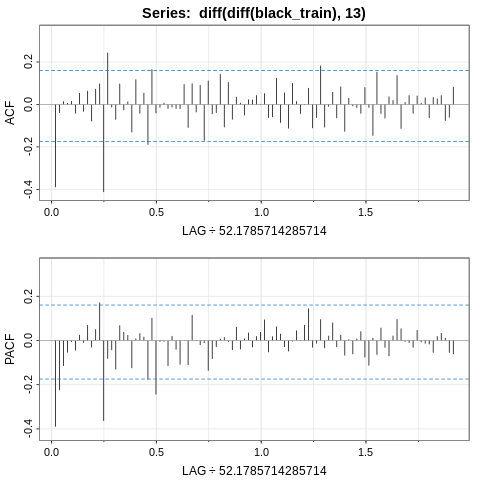

In [89]:
%%R
acf2(diff(diff(black_train),13), max.lag=100)

     [,1]  [,2]  [,3] [,4] [,5]  [,6]  [,7]  [,8] [,9] [,10] [,11] [,12] [,13]
ACF  -0.2 -0.35 -0.28 0.46 0.24 -0.32 -0.31  0.16 0.46 -0.23 -0.30 -0.09  0.47
PACF -0.2 -0.41 -0.57 0.01 0.23 -0.05 -0.12 -0.12 0.19 -0.07 -0.05 -0.16  0.00
     [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24] [,25]
ACF   0.01 -0.28 -0.25  0.39  0.20 -0.27 -0.28  0.14  0.41 -0.15 -0.30 -0.09
PACF -0.05 -0.02 -0.15  0.09  0.04 -0.07 -0.08 -0.09  0.03  0.00 -0.03 -0.08
     [,26] [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35] [,36] [,37]
ACF   0.40  0.05 -0.25 -0.23  0.25  0.27 -0.23 -0.21  0.01  0.41 -0.13 -0.17
PACF -0.08 -0.06 -0.01 -0.05 -0.08  0.00 -0.11  0.02 -0.11  0.05 -0.06  0.09
     [,38] [,39] [,40]
ACF  -0.20  0.40  0.01
PACF -0.12  0.04 -0.16


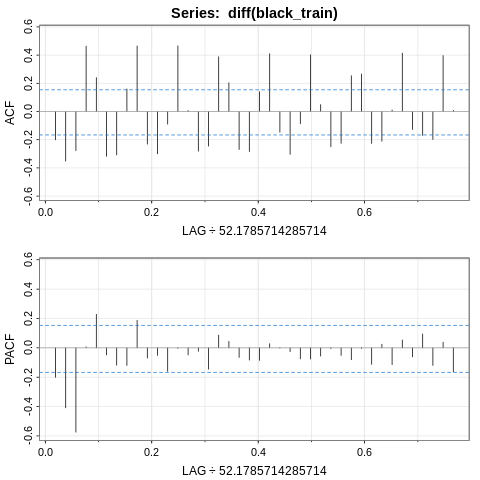

In [91]:
%%R
acf2(diff(black_train), max.lag=40)

initial  value 4.018625 
iter   2 value 3.753632
iter   3 value 3.749865
iter   4 value 3.739627
iter   5 value 3.738402
iter   6 value 3.738305
iter   7 value 3.738304
iter   8 value 3.738303
iter   8 value 3.738303
iter   8 value 3.738303
final  value 3.738303 
converged
initial  value 3.818706 
iter   2 value 3.814003
iter   3 value 3.812188
iter   4 value 3.812087
iter   5 value 3.812085
iter   6 value 3.812085
iter   6 value 3.812085
final  value 3.812085 
converged
$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    include.mean = !no.constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ma1     sar1
      -0.5200  -0.4740
s.e.   0.0717   0.0792

sigma^2 estimated as 1996:  log likelihood = -748.04,  aic = 1502.07

$degrees_of_freedom
[1] 141

$ttable
     Estimate     SE t.value p.value
ma1    -0.520 0.0717 -7.2576       0
sar1   -0.474 0.0

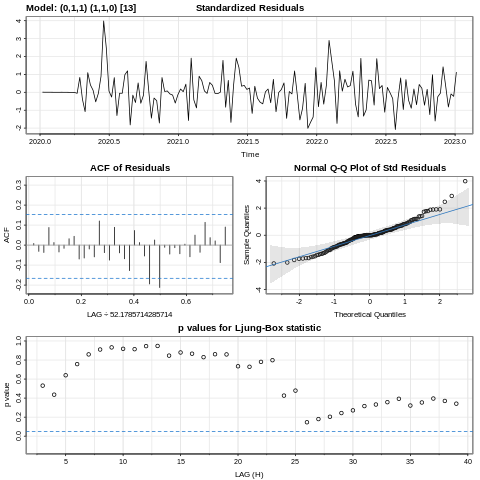

In [90]:
%%R
sarima(black_train, 0,1,1,1,1,0,13)

In [86]:
%%R
#prediction
#sarima.for(black_ts, n.ahead=6, p=0, d=1, q=0)
sarima.for(test, n.ahead=12,1,1,1,1,1,0,4)

  object 'test' not found




Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'test' not found


### Black plot

In [87]:
black_data=pd.read_csv('/content/black_month.csv')
ts=black_data[['DATE OCC','count']]
ts['month']=ts['DATE OCC'].str[:7].astype('string')
ts['month'] = pd.to_datetime(ts['month'], format='%Y-%m')
print(ts.head())

FileNotFoundError: ignored

In [ ]:
ts=ts[['month','count']]
ts.index = ts['month']
del ts['month']
print(ts.head())
ts_black=ts

In [ ]:
ts_black=pd.DataFrame({'date':date_range,'count':black['count']})
ts_black.index = ts_black['date']
del ts_black['date']
ts_black

In [ ]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

fig, ax = plt.subplots()
sns.lineplot(ts_black,palette=['g'],linewidth=2,ax=ax)
ax.set_ylim(1,1900)
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.title("Weekly Crime Count of Black")

## Hispanic

### Hispanic data

In [92]:
hispanic_count=df_hispanic.groupby('DATE OCC').size().reset_index(name='count')
hispanic_count

,DATE OCC,count
0,2020-01-01,487
1,2020-01-02,168
2,2020-01-03,173
3,2020-01-04,188
4,2020-01-05,176
...,...,...
1372,2023-10-04,138
1373,2023-10-05,135
1374,2023-10-06,153
1375,2023-10-07,155


In [93]:
hispanic_count=hispanic_count.loc[5:]
hispanic_count.reset_index(drop=True,inplace=True)

In [94]:
hispanic_count.drop('DATE OCC', axis=1, inplace=True)
hispanic_count.reset_index(drop=True)

<ipython-input-94-8b085907a810>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hispanic_count.drop('DATE OCC', axis=1, inplace=True)


,count
0,186
1,154
2,189
3,171
4,199
...,...
1367,138
1368,135
1369,153
1370,155


In [95]:
hispanic = hispanic_count.groupby(hispanic_count.index // 7 ).sum().reset_index(drop=True)
hispanic

,count
0,1290
1,1324
2,1371
3,1429
4,1334
...,...
191,1326
192,1197
193,1226
194,1223


In [96]:
hispanic.to_csv('hispanic_week.csv')

### Hispanic model

In [97]:
%%R
hispanic_dat<- read.csv('hispanic_week.csv')
#black_dat<- black_dat[,-1]

#asian_dat$Week<- as.Date(asian_dat$DATE.OCC)

head(hispanic_dat)

  X count
1 0  1290
2 1  1324
3 2  1371
4 3  1429
5 4  1334
6 5  1437


In [98]:
%%R
hispanic_ts <- ts(hispanic_dat$count, start = c(2020, 1), frequency = 365.25/7)
hispanic_ts

Time Series:
Start = 2020 
End = 2023.73716632444 
Frequency = 52.1785714285714 
  [1] 1290 1324 1371 1429 1334 1437 1334 1417 1267 1215  994 1028 1007  956 1082
 [16] 1146 1221 1151 1141 1143 1125 1056 1202 1287 1248 1343 1195 1150 1131 1200
 [31] 1149 1161 1245 1147 1213 1153 1110 1118 1254 1169 1162 1026 1118 1090  985
 [46] 1158 1008 1117 1028 1040 1057 1158 1017 1113 1131 1026 1156 1078 1182 1181
 [61] 1161 1060 1126 1114 1195 1133 1142 1091 1182 1208 1135 1142 1190 1201 1188
 [76] 1294 1215 1351 1309 1387 1353 1297 1325 1250 1297 1302 1398 1340 1237 1383
 [91] 1456 1286 1265 1199 1271 1427 1231 1206 1200 1397 1132 1156 1091 1263 1186
[106] 1152 1294 1158 1623 1307 1279 1251 1605 1277 1387 1347 1619 1449 1293 1318
[121] 1473 1682 1303 1305 1325 1829 1491 1305 1365 1665 1328 1318 1270 1294 1778
[136] 1274 1367 1370 1730 1458 1294 1355 1649 1553 1283 1398 1313 1743 1210 1189
[151] 1156 1778 1278 1273 1226 1449 1502 1254 1170 1242 1811 1332 1259 1166 1460
[166] 1282 1267 1185 1274 13

In [ ]:
%%R
#asian_ts<- ts(asian_dat$count, start=c(2020, 1), frequency=12)
plot(diff(hispanic_ts), main="Asian Victim Monthly Crime Count")

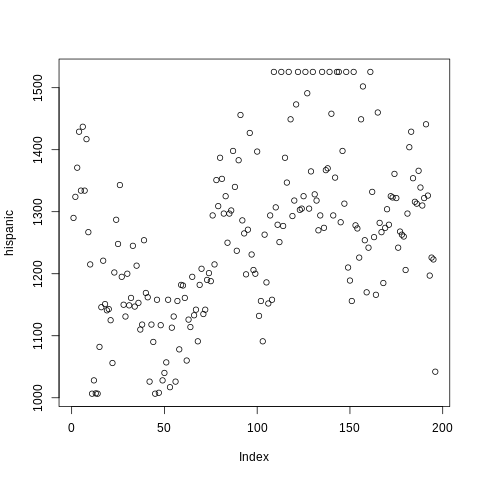

In [99]:
%%R
library(robustHD)
hispanic=winsorize(hispanic_ts,prob=c(0.1,0.9))
plot(hispanic)

In [100]:
%%R
hispanic=ts(hispanic, start = c(2020, 2), frequency = 365.25/7)
hispanic

Time Series:
Start = 2020.01916495551 
End = 2023.75633127995 
Frequency = 52.1785714285714 
  [1] 1290.000 1324.000 1371.000 1429.000 1334.000 1437.000 1334.000 1417.000
  [9] 1267.000 1215.000 1006.545 1028.000 1007.000 1006.545 1082.000 1146.000
 [17] 1221.000 1151.000 1141.000 1143.000 1125.000 1056.000 1202.000 1287.000
 [25] 1248.000 1343.000 1195.000 1150.000 1131.000 1200.000 1149.000 1161.000
 [33] 1245.000 1147.000 1213.000 1153.000 1110.000 1118.000 1254.000 1169.000
 [41] 1162.000 1026.000 1118.000 1090.000 1006.545 1158.000 1008.000 1117.000
 [49] 1028.000 1040.000 1057.000 1158.000 1017.000 1113.000 1131.000 1026.000
 [57] 1156.000 1078.000 1182.000 1181.000 1161.000 1060.000 1126.000 1114.000
 [65] 1195.000 1133.000 1142.000 1091.000 1182.000 1208.000 1135.000 1142.000
 [73] 1190.000 1201.000 1188.000 1294.000 1215.000 1351.000 1309.000 1387.000
 [81] 1353.000 1297.000 1325.000 1250.000 1297.000 1302.000 1398.000 1340.000
 [89] 1237.000 1383.000 1456.000 1286.000 1265.00

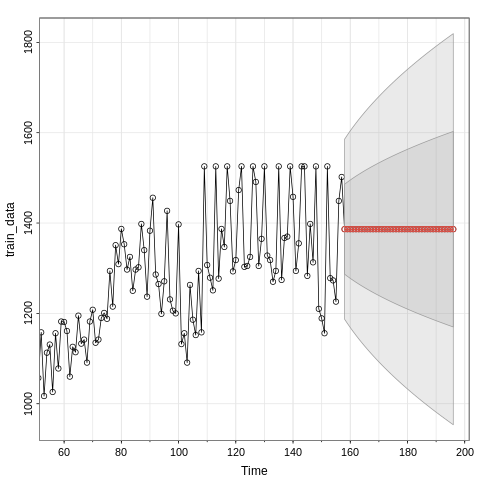

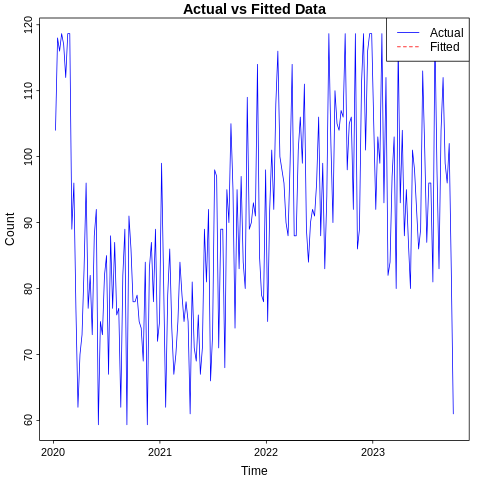

In [101]:
%%R
training_proportion <- 0.8
num_obs <- length(hispanic)
num_train <- round(num_obs * training_proportion)

# Split the data into training and testing sets
train_data <- hispanic[1:num_train]
test_data <- hispanic[(num_train + 1):length(asian)]

# Fit an ARIMA model to the training data
arima_model <- arima(train_data, order=c(2,1,1),seasonal = list(order = c(1, 1, 0), period = 4))  # You can adjust the order as needed

# Make predictions on the testing data
predicted_values <- sarima.for(train_data,n.ahead=length(test_data), p=0, d=1, q=1,no.constant=T)

# Plot the actual data and the fitted data together
plot(asian, main = 'Actual vs Fitted Data', col = 'blue', ylab = 'Count', xlab = 'Time')
lines(predicted_values$pred, col = 'red', lty = 2)  # Dashed line for fitted data
legend("topright", legend = c("Actual", "Fitted"), col = c('blue', 'red'), lty = c(1, 2))


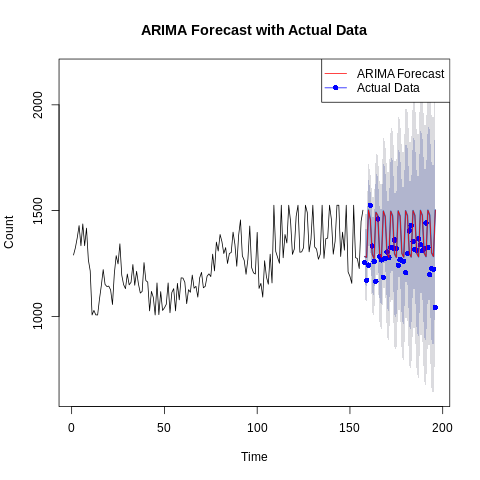

In [102]:
%%R
# Assuming 'sarima_forecast' is your SARIMA forecast object
sarima_forecast <- forecast(arima_model, h = length(test_data))

# Create a plot object
forecast_plot <- plot(sarima_forecast, main = 'ARIMA Forecast with Actual Data', ylab = 'Count', xlab = 'Time')
# Add the actual data points
points(158:196, test_data, col = 'blue', pch = 16)

# Add the prediction line with a custom color
lines(sarima_forecast$mean, col = 'red')
legend("topright", legend = c("ARIMA Forecast", "Actual Data"), col = c('red', 'blue'), lty = c(1, 1), pch = c(NA, 16))

# Save the plot to a file (optional)
# png("sarima_forecast_plot.png")
# print(forecast_plot)
# dev.off()


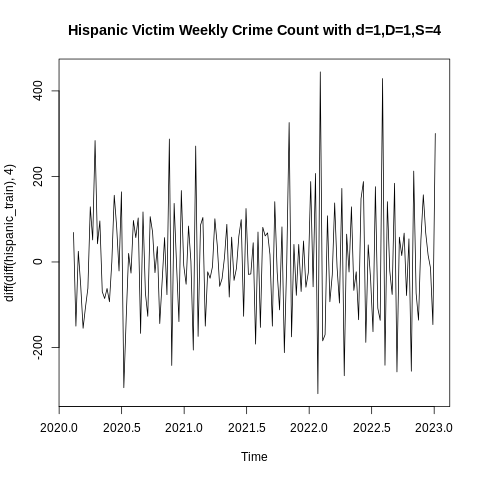

In [103]:
%%R
hispanic_train=ts(train_data,start=c(2020,2),frequency=365.25/7)
plot(diff(diff(hispanic_train),4),main="Hispanic Victim Weekly Crime Count with d=1,D=1,S=4")

      [,1]  [,2]  [,3]  [,4] [,5]  [,6]  [,7]  [,8] [,9] [,10] [,11] [,12]
ACF  -0.43  0.04 -0.30  0.34 0.03 -0.09 -0.24  0.06 0.36 -0.25 -0.01 -0.26
PACF -0.43 -0.18 -0.45 -0.02 0.19  0.02 -0.20 -0.26 0.24 -0.04  0.00 -0.21
     [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24]
ACF   0.45 -0.14 -0.08 -0.19  0.28  0.06 -0.14 -0.07 -0.04  0.35 -0.20 -0.07
PACF  0.04 -0.01 -0.19 -0.07  0.06  0.02 -0.12  0.05 -0.02  0.05  0.03 -0.06
     [,25] [,26] [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35] [,36]
ACF  -0.16  0.36 -0.09 -0.08 -0.17  0.17  0.22 -0.25  0.01 -0.09  0.29 -0.18
PACF -0.13 -0.04  0.01 -0.04 -0.06 -0.08  0.14 -0.04  0.07  0.06 -0.06 -0.13
     [,37] [,38] [,39] [,40] [,41] [,42] [,43] [,44] [,45] [,46] [,47] [,48]
ACF   0.09 -0.29  0.35 -0.10 -0.05 -0.09  0.09  0.09 -0.09 -0.05 -0.03  0.21
PACF  0.18 -0.01 -0.06 -0.06 -0.05  0.03  0.04 -0.03  0.06 -0.06  0.00 -0.01
     [,49] [,50] [,51] [,52] [,53] [,54] [,55] [,56] [,57] [,58] [,59] [,60]
ACF  

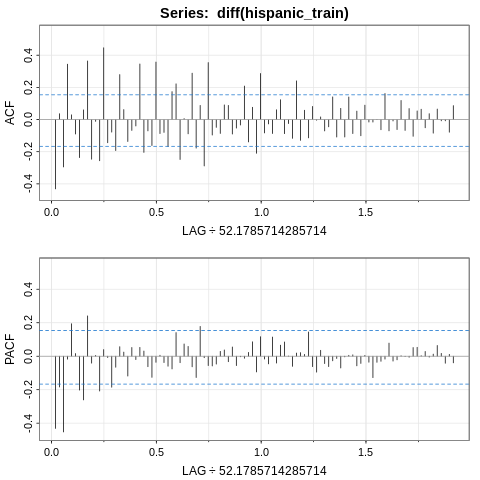

In [104]:
%%R
acf2(diff(hispanic_train), max.lag=100)

In [ ]:
%%R
plot(diff(diff(hispanic),4))

      [,1]  [,2] [,3]  [,4]  [,5]  [,6]  [,7]  [,8] [,9] [,10] [,11] [,12]
ACF  -0.46  0.09 0.09 -0.30  0.09  0.02 -0.12  0.05 0.21 -0.20  0.21 -0.28
PACF -0.46 -0.16 0.08 -0.26 -0.23 -0.06 -0.13 -0.23 0.16 -0.01  0.06 -0.30
     [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24]
ACF   0.17 -0.08 -0.01 -0.04  0.13 -0.04 -0.01  0.11 -0.15  0.19 -0.13 -0.01
PACF  0.10 -0.05 -0.05 -0.29  0.16 -0.05 -0.14 -0.10  0.20  0.04 -0.06 -0.14
     [,25] [,26] [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35] [,36]
ACF  -0.05  0.16 -0.16  0.14 -0.16  0.06  0.19 -0.21  0.09 -0.03 -0.01 -0.01
PACF  0.09  0.08 -0.16 -0.07 -0.07 -0.04  0.09  0.04 -0.08  0.04  0.05 -0.02
     [,37] [,38] [,39] [,40] [,41] [,42] [,43] [,44] [,45] [,46] [,47] [,48]
ACF   0.16 -0.30  0.26 -0.07 -0.09  0.13 -0.11  0.04  0.01 -0.07  0.03  0.04
PACF  0.14 -0.03 -0.07 -0.05  0.02  0.04 -0.04 -0.08  0.05 -0.06  0.06 -0.17
     [,49] [,50] [,51] [,52] [,53] [,54] [,55] [,56] [,57] [,58] [,59] [,60]
ACF  

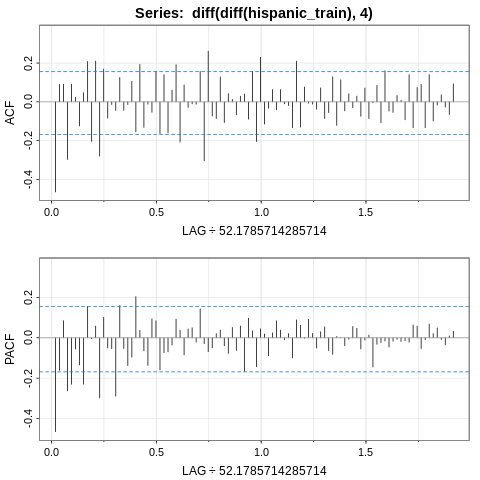

In [105]:
%%R
acf2(diff(diff(hispanic_train),4), max.lag=100)

initial  value 4.922425 
iter   2 value 4.719392
iter   3 value 4.674723
iter   4 value 4.670975
iter   5 value 4.670268
iter   6 value 4.669007
iter   7 value 4.668783
iter   8 value 4.668739
iter   8 value 4.668739
iter   8 value 4.668739
final  value 4.668739 
converged
initial  value 4.693419 
iter   2 value 4.691894
iter   3 value 4.690559
iter   4 value 4.687207
iter   5 value 4.666345
iter   6 value 4.654202
iter   7 value 4.652256
iter   8 value 4.649781
iter   9 value 4.644221
iter  10 value 4.641877
iter  11 value 4.641692
iter  12 value 4.641243
iter  13 value 4.641226
iter  14 value 4.641225
iter  15 value 4.641225
iter  15 value 4.641225
iter  15 value 4.641225
final  value 4.641225 
converged
$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    include.mean = !no.constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
         ar1     ar2     ma1

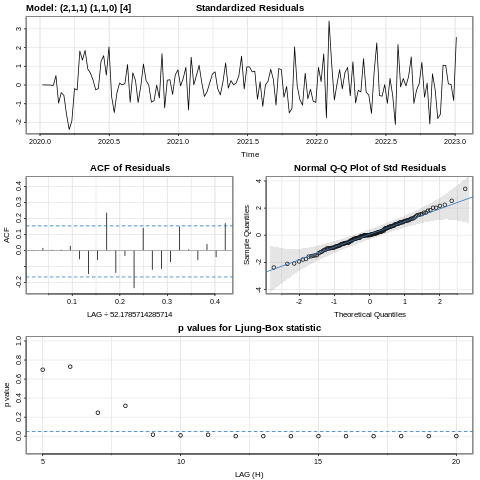

In [106]:
%%R
sarima(hispanic_train, 2,1,1,1,1,0,4)

In [ ]:
%%R
#prediction
#sarima.for(black_ts, n.ahead=6, p=0, d=1, q=0)
sarima.for(test, n.ahead=12,1,1,1,1,1,0,4)

### Hispanic plot

In [ ]:
hispanic_data=pd.read_csv('/content/hispanic_month.csv')
ts=hispanic_data[['DATE OCC','count']]
ts['month']=ts['DATE OCC'].str[:7].astype('string')
ts['month'] = pd.to_datetime(ts['month'], format='%Y-%m')
print(ts.head())

In [ ]:
ts=ts[['month','count']]
ts.index = ts['month']
del ts['month']
print(ts.head())
ts_hispanic=ts

In [ ]:
ts_hispanic=pd.DataFrame({'date':date_range,'count':hispanic['count']})
ts_hispanic.index = ts_hispanic['date']
del ts_hispanic['date']
ts_hispanic

In [ ]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

fig, ax = plt.subplots()
sns.lineplot(ts_hispanic,palette=['r'],linewidth=2,ax=ax)
ax.set_ylim(1,1900)
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.title("Weekly Crime Count of Hispanic")

## White

### White data

In [107]:
white_count=df_white.groupby('DATE OCC').size().reset_index(name='count')
white_count

,DATE OCC,count
0,2020-01-01,212
1,2020-01-02,104
2,2020-01-03,141
3,2020-01-04,101
4,2020-01-05,99
...,...,...
1372,2023-10-04,68
1373,2023-10-05,74
1374,2023-10-06,56
1375,2023-10-07,64


In [108]:
white_count=white_count.loc[5:]
white_count.reset_index(drop=True,inplace=True)

In [109]:
white_count.drop('DATE OCC', axis=1, inplace=True)
white_count.reset_index(drop=True)

<ipython-input-109-2ba22976f8f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_count.drop('DATE OCC', axis=1, inplace=True)


,count
0,117
1,120
2,113
3,139
4,149
...,...
1367,68
1368,74
1369,56
1370,64


In [110]:
white = white_count.groupby(white_count.index // 7 ).sum().reset_index(drop=True)
white

,count
0,847
1,953
2,887
3,997
4,872
...,...
191,771
192,747
193,723
194,673


In [111]:
white.to_csv('white_week.csv')

### White model

In [112]:
%%R
white_dat<- read.csv('white_week.csv')
#black_dat<- black_dat[,-1]

#asian_dat$Week<- as.Date(asian_dat$DATE.OCC)

head(white_dat)

  X count
1 0   847
2 1   953
3 2   887
4 3   997
5 4   872
6 5   855


In [113]:
%%R
white_ts <- ts(white_dat$count, start = c(2020, 1), frequency = 365.25/7)
white_ts

Time Series:
Start = 2020 
End = 2023.73716632444 
Frequency = 52.1785714285714 
  [1]  847  953  887  997  872  855  877  925  860  815  695  710  773  714  832
 [16]  824  849  813  787  832  903  816  790  886  850  888  765  814  790  834
 [31]  795  736  808  797  750  750  783  746  832  728  781  768  867  732  752
 [46]  794  831  820  801  767  764  825  748  831  820  791  846  792  803  813
 [61]  828  756  810  824  856  776  854  795  823  839  868  843  830  833  786
 [76]  847  822  973  882  903  841  841  844  866  848  859  891  847  860  917
 [91] 1030  865  878  907  932  964  940  846  813  947  901  857  805  795  857
[106]  845  864  811  979  918  894  836  934  869  904  884  967  962  849  913
[121] 1001  908  893  833  877 1009 1008  910  882  926  863  835  877  901  951
[136]  868  865  873  976  878  859  795  856  949  840  879  842  980  894  830
[151]  783  965  925  878  805  787  879  868  878  864 1066  930  943  827  894
[166]  798  840  831  866  8

In [ ]:
%%R
#asian_ts<- ts(asian_dat$count, start=c(2020, 1), frequency=12)
plot(diff(white_ts), main="Asian Victim Monthly Crime Count")

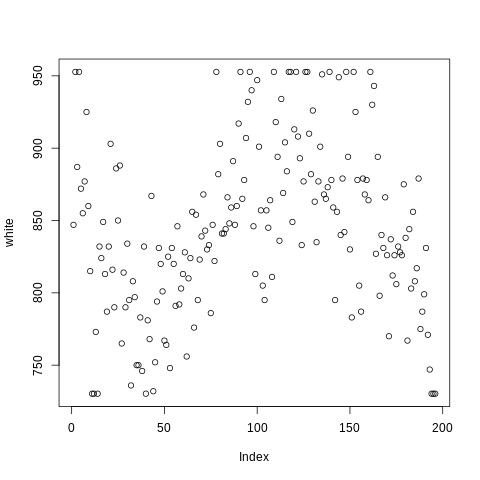

In [114]:
%%R
library(robustHD)
white=winsorize(white_ts,prob=c(0.1,0.9))
plot(white)

In [115]:
%%R
white=ts(white, start = c(2020, 2), frequency = 365.25/7)
white

Time Series:
Start = 2020.01916495551 
End = 2023.75633127995 
Frequency = 52.1785714285714 
  [1] 847.000 952.695 887.000 952.695 872.000 855.000 877.000 925.000 860.000
 [10] 815.000 730.305 730.305 773.000 730.305 832.000 824.000 849.000 813.000
 [19] 787.000 832.000 903.000 816.000 790.000 886.000 850.000 888.000 765.000
 [28] 814.000 790.000 834.000 795.000 736.000 808.000 797.000 750.000 750.000
 [37] 783.000 746.000 832.000 730.305 781.000 768.000 867.000 732.000 752.000
 [46] 794.000 831.000 820.000 801.000 767.000 764.000 825.000 748.000 831.000
 [55] 820.000 791.000 846.000 792.000 803.000 813.000 828.000 756.000 810.000
 [64] 824.000 856.000 776.000 854.000 795.000 823.000 839.000 868.000 843.000
 [73] 830.000 833.000 786.000 847.000 822.000 952.695 882.000 903.000 841.000
 [82] 841.000 844.000 866.000 848.000 859.000 891.000 847.000 860.000 917.000
 [91] 952.695 865.000 878.000 907.000 932.000 952.695 940.000 846.000 813.000
[100] 947.000 901.000 857.000 805.000 795.000 857

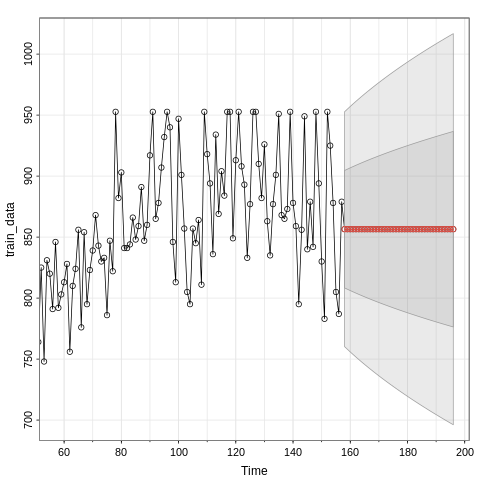

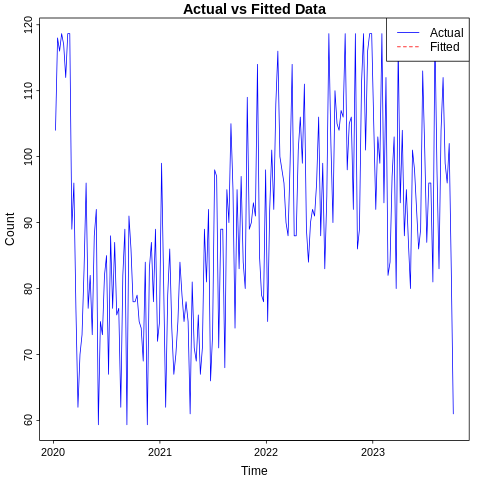

In [116]:
%%R
training_proportion <- 0.8
num_obs <- length(white)
num_train <- round(num_obs * training_proportion)

# Split the data into training and testing sets
train_data <- white[1:num_train]
test_data <- white[(num_train + 1):length(asian)]

# Fit an ARIMA model to the training data
arima_model <- arima(train_data, order=c(0,1,2),seasonal = list(order = c(2, 1, 0), period = 13))  # You can adjust the order as needed

# Make predictions on the testing data
predicted_values <- sarima.for(train_data,n.ahead=length(test_data), p=0, d=1, q=1,no.constant=T)

# Plot the actual data and the fitted data together
plot(asian, main = 'Actual vs Fitted Data', col = 'blue', ylab = 'Count', xlab = 'Time')
lines(predicted_values$pred, col = 'red', lty = 2)  # Dashed line for fitted data
legend("topright", legend = c("Actual", "Fitted"), col = c('blue', 'red'), lty = c(1, 2))


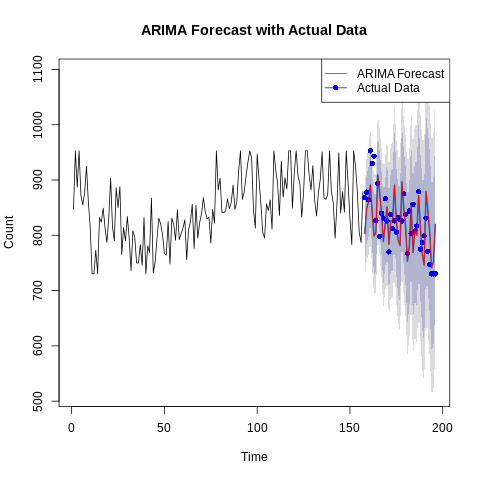

In [117]:
%%R
# Assuming 'sarima_forecast' is your SARIMA forecast object
sarima_forecast <- forecast(arima_model, h = length(test_data))

# Create a plot object
forecast_plot <- plot(sarima_forecast, main = 'ARIMA Forecast with Actual Data', ylab = 'Count', xlab = 'Time')
# Add the actual data points
points(158:196, test_data, col = 'blue', pch = 16)

# Add the prediction line with a custom color
lines(sarima_forecast$mean, col = 'red')
legend("topright", legend = c("ARIMA Forecast", "Actual Data"), col = c('red', 'blue'), lty = c(1, 1), pch = c(NA, 16))

# Save the plot to a file (optional)
# png("sarima_forecast_plot.png")
# print(forecast_plot)
# dev.off()


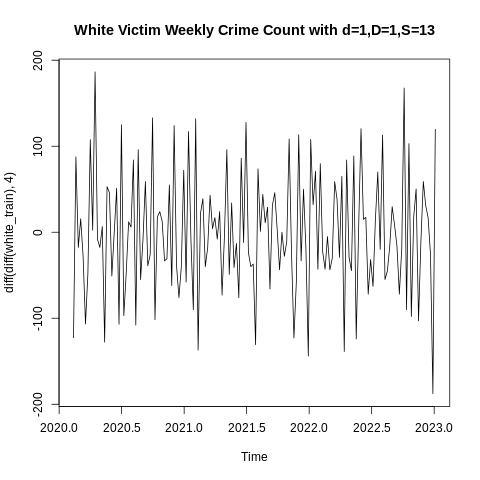

In [118]:
%%R
white_train=ts(train_data,start=c(2020,2),frequency=365.25/7)
plot(diff(diff(white_train),4),main="White Victim Weekly Crime Count with d=1,D=1,S=13")

In [ ]:
%%R
acf2(diff(white), max.lag=100)

In [ ]:
%%R
plot(diff(diff(white),4))

      [,1]  [,2]  [,3]  [,4]  [,5] [,6]  [,7]  [,8] [,9] [,10] [,11] [,12]
ACF  -0.31 -0.04 -0.19  0.08 -0.03 0.17 -0.14 -0.07 0.09  0.07 -0.08  0.21
PACF -0.31 -0.15 -0.29 -0.12 -0.13 0.08 -0.08 -0.16 0.04  0.05 -0.06  0.25
     [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24]
ACF  -0.43  0.05  0.07  0.10 -0.06  0.04 -0.02 -0.08  0.15 -0.08  0.03  0.05
PACF -0.32 -0.21 -0.07 -0.14 -0.05 -0.07  0.08 -0.12 -0.02  0.01  0.07  0.07
     [,25] [,26] [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35] [,36]
ACF  -0.05 -0.06  0.12 -0.02 -0.04 -0.02  0.08 -0.09  0.19 -0.14 -0.03 -0.06
PACF  0.11 -0.20 -0.05 -0.04 -0.08 -0.07  0.08  0.04  0.11  0.08  0.00 -0.02
     [,37] [,38] [,39] [,40] [,41] [,42] [,43] [,44] [,45] [,46] [,47] [,48]
ACF   0.09 -0.03  0.14 -0.08 -0.08  0.04  0.12 -0.12  0.00  -0.1  0.07  0.14
PACF  0.04  0.06  0.02  0.05 -0.03 -0.04  0.08  0.07 -0.04   0.0  0.03  0.11
     [,49] [,50] [,51] [,52] [,53] [,54] [,55] [,56] [,57] [,58] [,59] [,60]
ACF  

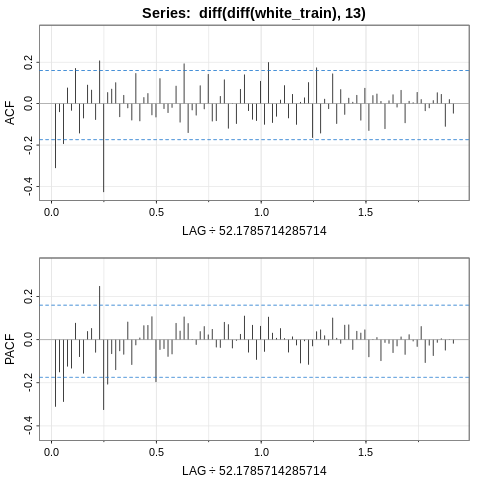

In [119]:
%%R
acf2(diff(diff(white_train),13), max.lag=100)

initial  value 4.123822 
iter   2 value 3.876987
iter   3 value 3.782112
iter   4 value 3.751180
iter   5 value 3.746835
iter   6 value 3.745558
iter   7 value 3.745523
iter   8 value 3.745491
iter   9 value 3.745489
iter   9 value 3.745489
iter   9 value 3.745489
final  value 3.745489 
converged
initial  value 3.798396 
iter   2 value 3.794927
iter   3 value 3.792885
iter   4 value 3.792790
iter   5 value 3.792785
iter   6 value 3.792785
iter   6 value 3.792785
iter   6 value 3.792785
final  value 3.792785 
converged
$fit

Call:
arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, Q), period = S), 
    include.mean = !no.constant, transform.pars = trans, fixed = fixed, optim.control = list(trace = trc, 
        REPORT = 1, reltol = tol))

Coefficients:
          ma1      ma2     sar1     sar2
      -0.5175  -0.1922  -0.7113  -0.3954
s.e.   0.0784   0.0785   0.0837   0.0835

sigma^2 estimated as 1850:  log likelihood = -745.28,  aic = 1500.55

$degrees_of_freedom
[1] 13

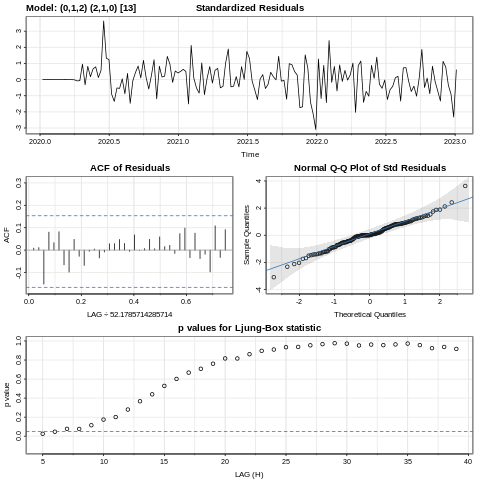

In [120]:
%%R
sarima(white_train, 0,1,2,2,1,0,13)

In [ ]:
%%R
#prediction
#sarima.for(black_ts, n.ahead=6, p=0, d=1, q=0)
sarima.for(white,n.ahead=12, 0,1,2,2,1,0,13)

### White plot

In [ ]:
white_data=pd.read_csv('/content/white_month.csv')
ts=white_data[['DATE OCC','count']]
ts['month']=ts['DATE OCC'].str[:7].astype('string')
ts['month'] = pd.to_datetime(ts['month'], format='%Y-%m')
print(ts.head())

In [ ]:
ts=ts[['month','count']]
ts.index = ts['month']
del ts['month']
print(ts.head())
ts_white=ts

In [ ]:
ts_white=pd.DataFrame({'date':date_range,'count':white['count']})
ts_white.index = ts_white['date']
del ts_white['date']
ts_white

In [ ]:
import seaborn as sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

fig, ax = plt.subplots()
sns.lineplot(ts_white,palette=['y'],linewidth=2,ax=ax)
ax.set_ylim(1,1900)
plt.ylabel('Crime Count')
plt.xticks(rotation=45)
plt.title("Weekly Crime Count of White")

## PLOT CRIME COUNT OVER VICTIM AGE
### Children: 0–12 years
### Adolescence: 13–18 years
### Adult: 19–59 years
### Senior adult: 60 years and above

In [ ]:
age = ['Children','Aolescence','Adult','Senior adult']
ranges = [[0,12],[13,18],[19,59],[60,100]]
col = ['blue','green','orange','red']
df_child = df_s[ (df_s['Vict Age']>=ranges[0][0]) & (df_s['Vict Age'] <= ranges[0][1])]
df_adol = df_s[ (df_s['Vict Age']>=ranges[1][0]) & (df_s['Vict Age'] <= ranges[1][1])]
df_adult = df_s[ (df_s['Vict Age']>=ranges[2][0]) & (df_s['Vict Age'] <= ranges[2][1])]
df_senior = df_s[ (df_s['Vict Age']>=ranges[3][0]) & (df_s['Vict Age'] <= ranges[3][1])]
df_age = [df_child,df_adol,df_adult,df_senior]

fig, axes = plt.subplots(1, 4, sharex=True,sharey=True,figsize = (32,6))

for i in range(4):

  df = df_age[i]
  # Calculate daily crime count (age)
  counts_age = df['DATE OCC'].value_counts().reset_index()
  counts_age = counts_age.sort_values(by = 'index')
  counts_age = counts_age.rename(columns={'index': 'DATE Occur','DATE OCC':'Daily Crime Number'})

  a = sns.lineplot(x=counts_age['DATE Occur'],y=counts_age['Daily Crime Number'],color =col[i],ax = axes[i] )
  #plt.xticks(rotation=45)
  #axes[i].set_xticks(count[i]['DATE Occur'])
  axes[i].set_title(f"Crime count with {age[i]} victims ")
  a.set(frame_on=False)


In [ ]:
# Plot Area histogram
# Convert area code to area name
area_name = ['Central', 'Rampart', 'Southwest', 'Hollenbeck', 'Harbor', 'Hollywood', 'Wilshire', 'West LA', 'Van Nuys', 'West Valley', 'Northeast', '77th Street', 'Newton', 'Pacific', 'N Hollywood', 'Foothill', 'Devonshire', 'Southeast', 'Mission', 'Olympic', 'Topanga']

plt.figure(figsize=(15,8))
a = sns.countplot(x=df_s['AREA'],palette="Paired")
# plt.xticks(rotation=45)
plt.xticks(ticks=plt.xticks()[0], labels=area_name,rotation=45)
plt.bar_label(a.containers[0],padding=7.0)
plt.title("Area and Count of Crimes")

a.set(frame_on=False)

In [ ]:
# Assign time to the closest hour: 1-24
def time(x):
  hour = int(x[:2])
  min = int(x[2:])
  if min == 0:
    return hour
  else:
    return hour+1
df_s['TIME OCC'] = df_s['TIME OCC'].apply(lambda x: time(x))

In [ ]:
# Plot histogram of hourly crime count
plt.figure(figsize=(15,8))
a = sns.countplot(x=df_s['TIME OCC'],palette="Paired")
plt.xticks(rotation=45)
#plt.xticks(ticks=plt.xticks()[0], labels=area_name,rotation=45)
plt.bar_label(a.containers[0],padding=7.0)
plt.title("Hourly Crime Count")
a.set(frame_on=False)

# Crime Code 510

In [ ]:
df_s

In [ ]:
df_s['Crm Cd'].value_counts().head(30)

In [ ]:
df_vehicle=df_s[df_s['Crm Cd']==510]
df_vehicle.reset_index(drop=True,inplace=True)
df_vehicle

In [ ]:
vehicle_count=df_vehicle.groupby('DATE OCC').size().reset_index(name='count')
vehicle_count

In [ ]:
count=[0]*196
for i in range(len(vehicle_count)):
  for j in range(len(date_range)):
    if j<195:
      if date_range[j]<vehicle_count['DATE OCC'][i] and date_range[j+1]>=vehicle_count['DATE OCC'][i]:
        count[j]+=vehicle_count['count'][i]
    else:
      if date_range[j]<vehicle_count['DATE OCC'][i]:
        count[j]+=vehicle_count['count'][i]
print(count)

In [ ]:
vehicle_count['DATE OCC'][0]

In [ ]:
date_range

In [ ]:
asian_count=asian_count.loc[5:]
asian_count.reset_index(drop=True,inplace=True)

In [ ]:
asian_count.drop('DATE OCC', axis=1, inplace=True)
asian_count.reset_index(drop=True)

In [ ]:
asian = asian_count.groupby(asian_count.index // 7 ).sum().reset_index(drop=True)


In [ ]:
asian

In [ ]:
asian.to_csv('asian_week.csv')